# Phase 1: 緊急改善の分析と検証

改善分析レポート（`.tmp/improvement-analysis.md`）で特定されたPhase 1項目を調査・検証する。

## 調査項目

1. **低的中率レース場の緊急デバッグ** — 若松(10%), 福岡(17%)等の原因特定
2. **レース場別イン有利度マップ** — 固定マップ→データ駆動24場×6枠マップへの変更
3. **日次数の特徴量復活** — exclude_colsから除外して効果を検証
4. **NaN処理の改善** — 履歴統計の0→3.5、今節データありフラグ追加
5. **未使用モデル削除の確認** — program_models.pkl, stadium_models.pkl の参照状況

## 0. セットアップ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
from pathlib import Path
from collections import defaultdict

matplotlib.rcParams['font.family'] = 'Hiragino Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

# リポジトリルート検出
cwd = Path.cwd()
repo_root = cwd if (cwd / 'data').exists() else cwd.parent.parent
print(f'repo_root: {repo_root}')

repo_root: /Users/mahiguch/dev/boatrace/data


In [2]:
STADIUM_CODE_TO_NAME = {
    1: '桐生', 2: '戸田', 3: '江戸川', 4: '平和島', 5: '多摩川',
    6: '浜名湖', 7: '蒲郡', 8: '常滑', 9: '津', 10: '三国',
    11: 'びわこ', 12: '住之江', 13: '尼崎', 14: '鳴門', 15: '丸亀',
    16: '児島', 17: '宮島', 18: '徳山', 19: '下関', 20: '若松',
    21: '芦屋', 22: '福岡', 23: '唐津', 24: '大村',
}

STADIUM_NAME_TO_CODE = {
    f'ボートレース{name}': code for code, name in STADIUM_CODE_TO_NAME.items()
}
STADIUM_NAME_TO_CODE['ボートレース琵琶湖'] = 11  # 別名

# 短縮名→コード
SHORT_NAME_TO_CODE = {name: code for code, name in STADIUM_CODE_TO_NAME.items()}

## 1. 低的中率レース場の緊急デバッグ

confirmデータからレース場別の的中率を算出し、問題のあるレース場を特定する。

In [3]:
# confirmデータの読み込み
confirm_dfs = []
for year_month in [('2026', '01'), ('2026', '02')]:
    year, month = year_month
    confirm_dir = repo_root / 'data' / 'confirm' / year / month
    if confirm_dir.exists():
        for f in sorted(confirm_dir.glob('*.csv')):
            df = pd.read_csv(f, dtype={'レースコード': str})
            confirm_dfs.append(df)

confirm = pd.concat(confirm_dfs, ignore_index=True)
print(f'confirmデータ: {len(confirm)} レース')
print(f'期間: {confirm["レースコード"].str[:8].min()} ~ {confirm["レースコード"].str[:8].max()}')
confirm.head()

confirmデータ: 2125 レース
期間: 20260120 ~ 20260208


,レースコード,予想1着,予想2着,予想3着,実際1着,実際2着,実際3着,1着的中,2着的中,3着的中,全的中
0,202601200201,1,4,2,4,5,2.0,×,×,○,×
1,202601200202,2,3,5,1,2,4.0,×,×,×,×
2,202601200203,2,5,6,2,5,1.0,○,○,×,×
3,202601200204,3,6,2,2,1,3.0,×,×,×,×
4,202601200205,6,5,4,1,6,3.0,×,×,×,×


In [4]:
# レースコードからレース場コードを抽出 (先頭8桁=YYYYMMDD, 9-10桁目=場コード)
confirm['場コード'] = confirm['レースコード'].str[8:10].astype(int)
confirm['場名'] = confirm['場コード'].map(STADIUM_CODE_TO_NAME)

# レース場別的中率
stadium_accuracy = confirm.groupby(['場コード', '場名']).agg(
    レース数=('1着的中', 'count'),
    _1着的中数=('1着的中', lambda x: (x == '○').sum()),
    _2着的中数=('2着的中', lambda x: (x == '○').sum()),
    _3着的中数=('3着的中', lambda x: (x == '○').sum()),
    _全的中数=('全的中', lambda x: (x == '○').sum()),
).reset_index()

stadium_accuracy['1着的中率'] = (stadium_accuracy['_1着的中数'] / stadium_accuracy['レース数'] * 100).round(1)
stadium_accuracy['2着的中率'] = (stadium_accuracy['_2着的中数'] / stadium_accuracy['レース数'] * 100).round(1)
stadium_accuracy['3着的中率'] = (stadium_accuracy['_3着的中数'] / stadium_accuracy['レース数'] * 100).round(1)
stadium_accuracy['全的中率'] = (stadium_accuracy['_全的中数'] / stadium_accuracy['レース数'] * 100).round(1)

display_cols = ['場コード', '場名', 'レース数', '1着的中率', '2着的中率', '3着的中率', '全的中率']
print('=== レース場別的中率（2026年1-2月） ===')
print(stadium_accuracy[display_cols].sort_values('1着的中率', ascending=False).to_string(index=False))

=== レース場別的中率（2026年1-2月） ===
 場コード  場名  レース数  1着的中率  2着的中率  3着的中率  全的中率
   24  大村    72   66.7   30.6   20.8  11.1
   15  丸亀    72   61.1   27.8    8.3   4.2
   17  宮島   108   59.3   16.7   25.9   4.6
   12 住之江   108   58.3   21.3   23.1   8.3
   10  三国   120   56.7   25.8   14.2   2.5
   19  下関    96   56.2   21.9   18.8   7.3
    7  蒲郡   120   55.0   24.2   16.7   5.8
   23  唐津   100   54.0   32.0   21.0   5.0
   13  尼崎    36   52.8   19.4   19.4   5.6
   16  児島   108   51.9   32.4   19.4   7.4
    8  常滑    71   50.7   16.9   12.7   2.8
    5 多摩川    72   50.0   18.1   23.6   4.2
   18  徳山    96   47.9   30.2   22.9   3.1
   14  鳴門   108   46.3   26.9   12.0   1.9
    9   津    33   42.4   21.2   15.2   3.0
    6 浜名湖    96   39.6   16.7   24.0   4.2
    4 平和島   132   37.9   18.2   20.5   3.8
    1  桐生   132   37.1   27.3   12.9   2.3
    3 江戸川    96   31.2   16.7   19.8   2.1
   11 びわこ   112   30.4   17.0   13.4   0.0
   21  芦屋    46   28.3   17.4   15.2   0.0
    2  戸田    96   24.0   2

In [5]:
# 1号艇予想率 vs 実際の1号艇勝率
confirm['予想1着_is_1'] = (confirm['予想1着'] == 1).astype(int)
confirm['実際1着_is_1'] = (confirm['実際1着'] == 1).astype(int)

boat1_analysis = confirm.groupby(['場コード', '場名']).agg(
    レース数=('予想1着', 'count'),
    _1号艇予想数=('予想1着_is_1', 'sum'),
    _1号艇実勝利数=('実際1着_is_1', 'sum'),
).reset_index()

boat1_analysis['1号艇予想率'] = (boat1_analysis['_1号艇予想数'] / boat1_analysis['レース数'] * 100).round(1)
boat1_analysis['実際1号艇勝率'] = (boat1_analysis['_1号艇実勝利数'] / boat1_analysis['レース数'] * 100).round(1)
boat1_analysis['乖離'] = (boat1_analysis['1号艇予想率'] - boat1_analysis['実際1号艇勝率']).round(1)

# 1着的中率もマージ
boat1_analysis = boat1_analysis.merge(
    stadium_accuracy[['場コード', '1着的中率']], on='場コード'
)

display_cols = ['場コード', '場名', 'レース数', '1号艇予想率', '実際1号艇勝率', '乖離', '1着的中率']
print('=== 1号艇予想率 vs 実際1号艇勝率 ===')
print(boat1_analysis[display_cols].sort_values('1着的中率', ascending=True).to_string(index=False))

=== 1号艇予想率 vs 実際1号艇勝率 ===


 場コード  場名  レース数  1号艇予想率  実際1号艇勝率    乖離  1着的中率
   20  若松    60     3.3     58.3 -55.0   10.0
   22  福岡    35     0.0     60.0 -60.0   17.1
    2  戸田    96    49.0     39.6   9.4   24.0
   21  芦屋    46    32.6     63.0 -30.4   28.3
   11 びわこ   112    51.8     51.8   0.0   30.4
    3 江戸川    96    71.9     46.9  25.0   31.2
    1  桐生   132    67.4     34.8  32.6   37.1
    4 平和島   132    74.2     43.2  31.0   37.9
    6 浜名湖    96    72.9     44.8  28.1   39.6
    9   津    33    72.7     51.5  21.2   42.4
   14  鳴門   108    88.9     49.1  39.8   46.3
   18  徳山    96    81.2     62.5  18.7   47.9
    5 多摩川    72    84.7     58.3  26.4   50.0
    8  常滑    71    67.6     56.3  11.3   50.7
   16  児島   108    85.2     60.2  25.0   51.9
   13  尼崎    36    61.1     69.4  -8.3   52.8
   23  唐津   100    93.0     59.0  34.0   54.0
    7  蒲郡   120    79.2     61.7  17.5   55.0
   19  下関    96    83.3     64.6  18.7   56.2
   10  三国   120    78.3     64.2  14.1   56.7
   12 住之江   108    99.1     59.3 

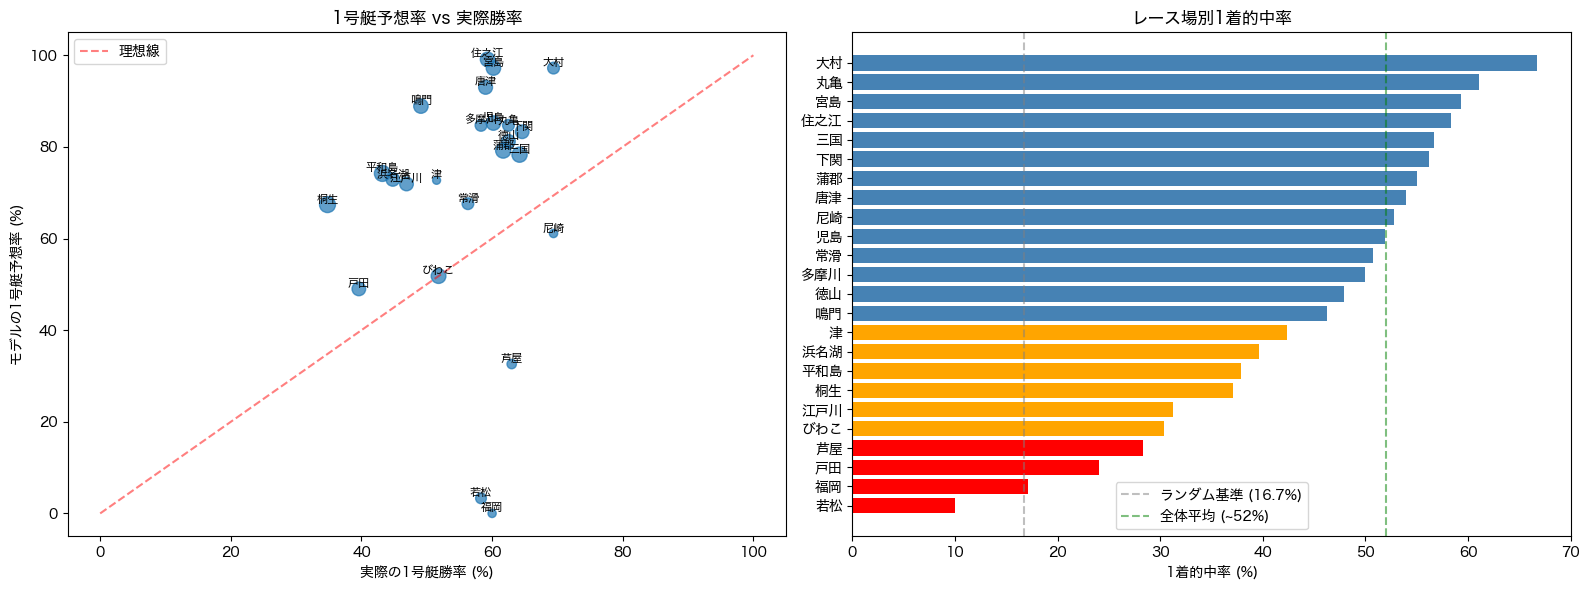

In [6]:
# 可視化: 1号艇予想率 vs 実際勝率 vs 的中率
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 散布図: 1号艇予想率 vs 実際勝率
ax = axes[0]
ax.scatter(boat1_analysis['実際1号艇勝率'], boat1_analysis['1号艇予想率'],
           s=boat1_analysis['レース数'], alpha=0.7)
for _, row in boat1_analysis.iterrows():
    ax.annotate(row['場名'], (row['実際1号艇勝率'], row['1号艇予想率']),
                fontsize=8, ha='center', va='bottom')
ax.plot([0, 100], [0, 100], 'r--', alpha=0.5, label='理想線')
ax.set_xlabel('実際の1号艇勝率 (%)')
ax.set_ylabel('モデルの1号艇予想率 (%)')
ax.set_title('1号艇予想率 vs 実際勝率')
ax.legend()

# 棒グラフ: レース場別1着的中率
ax = axes[1]
sorted_data = stadium_accuracy.sort_values('1着的中率', ascending=True)
colors = ['red' if x < 30 else 'orange' if x < 45 else 'steelblue' for x in sorted_data['1着的中率']]
ax.barh(sorted_data['場名'], sorted_data['1着的中率'], color=colors)
ax.axvline(x=16.7, color='gray', linestyle='--', alpha=0.5, label='ランダム基準 (16.7%)')
ax.axvline(x=52, color='green', linestyle='--', alpha=0.5, label='全体平均 (~52%)')
ax.set_xlabel('1着的中率 (%)')
ax.set_title('レース場別1着的中率')
ax.legend()

plt.tight_layout()
plt.show()

### 1.1 問題レース場の詳細デバッグ

的中率が特に低いレース場について、予測内容を詳しく調べる。

In [7]:
# 問題レース場の予測パターン分析
problem_stadiums = boat1_analysis.nsmallest(5, '1着的中率')['場コード'].tolist()
good_stadiums = boat1_analysis.nlargest(5, '1着的中率')['場コード'].tolist()

for label, stadiums in [('低的中率レース場', problem_stadiums), ('高的中率レース場', good_stadiums)]:
    print(f'\n=== {label} の予想着順分布 ===')
    subset = confirm[confirm['場コード'].isin(stadiums)]
    for stadium_code in stadiums:
        s = subset[subset['場コード'] == stadium_code]
        name = STADIUM_CODE_TO_NAME[stadium_code]
        pred_dist = s['予想1着'].value_counts().sort_index()
        actual_dist = s['実際1着'].value_counts().sort_index()
        print(f'\n  {name}（場{stadium_code}）- {len(s)}レース')
        print(f'  予想1着分布: {dict(pred_dist)}')
        print(f'  実際1着分布: {dict(actual_dist)}')


=== 低的中率レース場 の予想着順分布 ===

  若松（場20）- 60レース
  予想1着分布: {1: np.int64(2), 2: np.int64(48), 3: np.int64(4), 4: np.int64(3), 6: np.int64(3)}
  実際1着分布: {1: np.int64(35), 2: np.int64(7), 3: np.int64(6), 4: np.int64(6), 5: np.int64(3), 6: np.int64(3)}

  福岡（場22）- 35レース
  予想1着分布: {3: np.int64(35)}
  実際1着分布: {1: np.int64(21), 2: np.int64(5), 3: np.int64(6), 4: np.int64(3)}

  戸田（場2）- 96レース
  予想1着分布: {1: np.int64(47), 2: np.int64(18), 3: np.int64(10), 4: np.int64(10), 5: np.int64(4), 6: np.int64(7)}
  実際1着分布: {1: np.int64(38), 2: np.int64(14), 3: np.int64(18), 4: np.int64(16), 5: np.int64(7), 6: np.int64(3)}

  芦屋（場21）- 46レース
  予想1着分布: {1: np.int64(15), 3: np.int64(30), 6: np.int64(1)}
  実際1着分布: {1: np.int64(29), 2: np.int64(5), 3: np.int64(3), 4: np.int64(6), 5: np.int64(3)}

  びわこ（場11）- 112レース
  予想1着分布: {1: np.int64(58), 2: np.int64(10), 3: np.int64(10), 4: np.int64(6), 5: np.int64(28)}
  実際1着分布: {1: np.int64(58), 2: np.int64(14), 3: np.int64(17), 4: np.int64(13), 5: np.int64(8), 6: np.int64(2)

In [8]:
# モデル内部の確認: 問題レース場のモデルが正しくロードされているか
model_path = repo_root / 'models' / 'program_models_v2.pkl'
with open(model_path, 'rb') as f:
    models = pickle.load(f)

print('=== モデル格納キー ===')
stadium_keys = [k for k in models.keys() if not isinstance(k, str)]
meta_keys = [k for k in models.keys() if isinstance(k, str)]
print(f'レース場数: {len(stadium_keys)}')
print(f'キー一覧: {sorted(stadium_keys)}')
print(f'\nメタキー: {meta_keys}')

# 問題レース場のモデル存在確認
for code in problem_stadiums:
    name = STADIUM_CODE_TO_NAME[code]
    has_model = code in models
    print(f'\n場{code}（{name}）: モデル{"あり" if has_model else "なし"}')
    if has_model:
        entry = models[code]
        print(f'  特徴量数: {len(entry["features"])}')
        print(f'  ranking_model: {type(entry.get("ranking_model", None))}')
        print(f'  model: {type(entry.get("model", None))}')


=== モデル格納キー ===
レース場数: 24
キー一覧: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24)]

メタキー: ['_ensemble_weights', '_player_stats', '_stadium_player_stats']

場20（若松）: モデルあり
  特徴量数: 33
  ranking_model: <class 'lightgbm.basic.Booster'>
  model: <class 'lightgbm.sklearn.LGBMClassifier'>

場22（福岡）: モデルあり
  特徴量数: 33
  ranking_model: <class 'lightgbm.basic.Booster'>
  model: <class 'lightgbm.sklearn.LGBMClassifier'>

場2（戸田）: モデルあり
  特徴量数: 33
  ranking_model: <class 'lightgbm.basic.Booster'>
  model: <class 'lightgbm.sklearn.LGBMClassifier'>

場21（芦屋）: モデルあり
  特徴量数: 33
  ranking_model: <class 'lightgbm.basic.Booster'>
  model: <class 'lightgbm.sklearn.LGBMClassifier'>

場11（びわこ）: モデルあり
  特徴量数: 33
  ranking_model: <class 'light

In [9]:
# prediction-preview のコース予測値を確認（問題の核心）
print('=== prediction-preview のコース予測確認 ===')
for year_month_day in [('2026', '02', '01'), ('2026', '02', '02')]:
    y, m, d = year_month_day
    pp_path = repo_root / 'data' / 'prediction-preview' / y / m / f'{d}.csv'
    if pp_path.exists():
        pp = pd.read_csv(pp_path, dtype={'レースコード': str})
        print(f'\n--- {y}/{m}/{d} ---')
        # コース列の分布を確認
        for boat_n in range(1, 7):
            col = f'艇{boat_n}_コース'
            if col in pp.columns:
                vals = pp[col]
                print(f'  {col}: mean={vals.mean():.2f}, min={vals.min():.2f}, max={vals.max():.2f}, '
                      f'値分布={dict(vals.round().astype(int).value_counts().sort_index())}')
    else:
        print(f'{pp_path} が存在しない')

=== prediction-preview のコース予測確認 ===

--- 2026/02/01 ---
  艇1_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(166)}
  艇2_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(166)}
  艇3_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(166)}
  艇4_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(166)}
  艇5_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(166)}
  艇6_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(166)}

--- 2026/02/02 ---
  艇1_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(167)}
  艇2_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(167)}
  艇3_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(167)}
  艇4_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(167)}
  艇5_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(167)}
  艇6_コース: mean=1.00, min=1.00, max=1.00, 値分布={1: np.int64(167)}


In [10]:
# 問題レース場のprediction-previewデータを抽出して詳細確認
print('=== 問題レース場の prediction-preview 詳細 ===')
for y, m in [('2026', '02')]:
    pp_dir = repo_root / 'data' / 'prediction-preview' / y / m
    if not pp_dir.exists():
        continue
    for f in sorted(pp_dir.glob('*.csv')):
        pp = pd.read_csv(f, dtype={'レースコード': str})
        pp['場コード'] = pp['レースコード'].str[8:10].astype(int)
        for code in problem_stadiums:
            subset = pp[pp['場コード'] == code]
            if len(subset) == 0:
                continue
            name = STADIUM_CODE_TO_NAME[code]
            print(f'\n{name}（場{code}）- {f.name}: {len(subset)}レース')
            # 各艇の展示タイム・コース・ST展示の統計
            for boat_n in range(1, 7):
                et = subset[f'艇{boat_n}_展示タイム']
                cs = subset[f'艇{boat_n}_コース']
                st = subset[f'艇{boat_n}_スタート展示']
                print(f'  艇{boat_n}: 展示={et.mean():.4f}(±{et.std():.4f}), '
                      f'コース={cs.mean():.2f}, ST展示={st.mean():.4f}')

=== 問題レース場の prediction-preview 詳細 ===

福岡（場22）- 01.csv: 12レース
  艇1: 展示=6.7411(±0.0454), コース=1.00, ST展示=0.1127
  艇2: 展示=6.7397(±0.0438), コース=1.00, ST展示=0.1069
  艇3: 展示=6.7287(±0.0373), コース=1.00, ST展示=0.1207
  艇4: 展示=6.7415(±0.0425), コース=1.00, ST展示=0.1330
  艇5: 展示=6.7506(±0.0489), コース=1.00, ST展示=0.1401
  艇6: 展示=6.7391(±0.0467), コース=1.00, ST展示=0.1300

戸田（場2）- 01.csv: 12レース
  艇1: 展示=6.8050(±0.0202), コース=1.00, ST展示=0.0225
  艇2: 展示=6.8001(±0.0162), コース=1.00, ST展示=0.0188
  艇3: 展示=6.8004(±0.0344), コース=1.00, ST展示=0.0402
  艇4: 展示=6.8085(±0.0356), コース=1.00, ST展示=0.0541
  艇5: 展示=6.8027(±0.0243), コース=1.00, ST展示=0.0144
  艇6: 展示=6.8002(±0.0245), コース=1.00, ST展示=-0.0036

芦屋（場21）- 01.csv: 10レース
  艇1: 展示=6.8513(±0.0247), コース=1.00, ST展示=0.1395
  艇2: 展示=6.8682(±0.0322), コース=1.00, ST展示=0.1410
  艇3: 展示=6.8661(±0.0487), コース=1.00, ST展示=0.1554
  艇4: 展示=6.8377(±0.0409), コース=1.00, ST展示=0.1313
  艇5: 展示=6.8781(±0.0382), コース=1.00, ST展示=0.1657
  艇6: 展示=6.8542(±0.0511), コース=1.00, ST展示=0.2047

戸田（場2）- 02.csv: 12レース
  艇

### 1.2 estimate.py のアンサンブルスコア再現

問題レース場で実際にモデルが何を出力しているか再現する。

In [11]:
import sys
sys.path.insert(0, str(repo_root / 'scripts'))

from boatrace.converter import (
    PROGRAMS_HEADERS, RESULTS_HEADERS, PREVIEWS_HEADERS
)

def reshape_programs(programs_df):
    """ワイド形式のprogramsをロング形式に変換"""
    race_cols = ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回', 'レース名', '距離(m)', '電話投票締切予定']
    frames = []
    for n in range(1, 7):
        prefix = f'{n}枠_'
        boat_cols = [c for c in programs_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = programs_df[race_cols + boat_cols].rename(columns=rename_map)
        frame['枠'] = n
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

def reshape_previews(previews_df):
    """ワイド形式のpreviewsをロング形式に変換"""
    race_cols = [c for c in previews_df.columns if not c.startswith('艇')]
    frames = []
    for n in range(1, 7):
        prefix = f'艇{n}_'
        boat_cols = [c for c in previews_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = previews_df[race_cols + boat_cols].rename(columns=rename_map)
        frame['艇番'] = n
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

def reshape_results(results_df):
    """ワイド形式のresultsをロング形式に変換"""
    race_cols = ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回',
                 'レース名', '距離(m)', '天候', '風向', '風速(m)', '波の高さ(cm)', '決まり手']
    frames = []
    for n in range(1, 7):
        prefix = f'{n}着_'
        boat_cols = [c for c in results_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = results_df[race_cols + boat_cols].rename(columns=rename_map)
        frame['着順'] = n
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

print('ヘルパー関数定義完了')

ヘルパー関数定義完了


In [12]:
# 特徴量エンジニアリング関数（estimate.py 準拠）

def compute_konseki_features(df):
    """今節成績から特徴量を計算"""
    place_cols = [f'今節成績_{i}-2' for i in range(1, 7)]
    existing_place_cols = [c for c in place_cols if c in df.columns]
    if not existing_place_cols:
        df['今節_平均着順'] = np.nan
        df['今節_1着回数'] = np.nan
        df['今節_3連対率'] = np.nan
        df['今節_出走回数'] = 0
        df['今節_最新着順'] = np.nan
        return df
    place_data = df[existing_place_cols].copy()
    place_data = place_data.replace(0, np.nan)
    place_data = place_data.apply(pd.to_numeric, errors='coerce')
    df['今節_出走回数'] = place_data.notna().sum(axis=1)
    df['今節_平均着順'] = place_data.mean(axis=1)
    df['今節_1着回数'] = (place_data == 1).sum(axis=1)
    df['今節_3連対率'] = (place_data <= 3).sum(axis=1) / df['今節_出走回数'].replace(0, np.nan)
    last_valid = place_data.ffill(axis=1).iloc[:, -1]
    df['今節_最新着順'] = last_valid
    return df

def compute_relative_features(df):
    """レース内相対特徴量を計算"""
    if '全国勝率' in df.columns:
        race_groups = df.groupby('レースコード')['全国勝率']
        df['全国勝率_偏差'] = df['全国勝率'] - race_groups.transform('mean')
        df['全国勝率_最大差'] = df['全国勝率'] - race_groups.transform('max')
    if 'モーター2連対率' in df.columns:
        df['モーター2連対率_順位'] = df.groupby('レースコード')['モーター2連対率'].rank(ascending=False)
    if '当地勝率' in df.columns:
        race_groups = df.groupby('レースコード')['当地勝率']
        df['当地勝率_偏差'] = df['当地勝率'] - race_groups.transform('mean')
    return df

def compute_course_features(df, in_advantage_map=None):
    """コース特徴量を計算（イン有利度マップをパラメータ化）"""
    if in_advantage_map is None:
        in_advantage_map = {1: 5, 2: 3, 3: 2, 4: 1, 5: 0, 6: 0}  # 現行の固定マップ
    if '全国勝率' in df.columns and '枠' in df.columns:
        df['枠×全国勝率'] = df['枠'] * df['全国勝率'].fillna(0)
    if '枠' in df.columns:
        df['イン有利度'] = df['枠'].map(in_advantage_map).fillna(0)
    return df

def prepare_features(data, feature_cols):
    """特徴量行列の準備（NaN処理込み）"""
    X = pd.DataFrame(index=data.index)
    for col in feature_cols:
        if col in data.columns:
            X[col] = pd.to_numeric(data[col], errors='coerce')
        else:
            X[col] = 0.0
    for col in X.columns:
        if X[col].notna().any():
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)
        else:
            X[col] = X[col].fillna(0)
    return X

print('特徴量エンジニアリング関数定義完了')

特徴量エンジニアリング関数定義完了


In [13]:
# 1日分のデータで問題レース場の予測を再現
target_date = ('2026', '02', '01')
y, m, d = target_date

# データ読み込み
prog_path = repo_root / 'data' / 'programs' / y / m / f'{d}.csv'
pp_path = repo_root / 'data' / 'prediction-preview' / y / m / f'{d}.csv'

programs_raw = pd.read_csv(prog_path, dtype={'レースコード': str})
programs_long = reshape_programs(programs_raw)

previews_raw = pd.read_csv(pp_path, dtype={'レースコード': str}) if pp_path.exists() else None
previews_long = reshape_previews(previews_raw) if previews_raw is not None else None

# マージ
merged = programs_long.copy()
if previews_long is not None:
    preview_cols = ['レースコード', '艇番', 'コース', 'スタート展示', 'チルト調整', '展示タイム']
    existing_cols = [c for c in preview_cols if c in previews_long.columns]
    merged = merged.merge(
        previews_long[existing_cols],
        left_on=['レースコード', '枠'],
        right_on=['レースコード', '艇番'],
        how='left',
        suffixes=('', '_preview')
    )
    for col in ['コース', 'スタート展示', 'チルト調整', '展示タイム']:
        if col in previews_long.columns:
            merged[col] = merged.get(f'{col}_preview', merged.get(col))

# レース場コード
merged['場コード'] = merged['レース場'].map(STADIUM_NAME_TO_CODE)

# 特徴量生成
merged = compute_konseki_features(merged)
merged = compute_relative_features(merged)
merged = compute_course_features(merged)

# 級別エンコード
grade_map = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3}
merged['級別_encoded'] = merged['級別'].map(grade_map).fillna(3)

# player_stats マージ
player_stats = models.get('_player_stats')
stadium_player_stats = models.get('_stadium_player_stats')
if player_stats is not None:
    merged['登録番号'] = pd.to_numeric(merged['登録番号'], errors='coerce')
    merged = merged.merge(player_stats, on='登録番号', how='left')
if stadium_player_stats is not None:
    merged = merged.merge(
        stadium_player_stats,
        left_on=['登録番号', '場コード'],
        right_on=['登録番号', 'レース場'],
        how='left',
        suffixes=('', '_stadium_stat')
    )

print(f'データ形状: {merged.shape}')
print(f'レース場: {merged["場コード"].unique()}')

データ形状: (996, 64)
レース場: [23 22 21 19 16 14 13 12 10  7  6  4  2  1]


In [14]:
# 問題レース場でのモデルスコアを詳細に表示
ensemble_weights = models.get('_ensemble_weights', (0.7, 0.2, 0.1))
w_rank, w_cls, w_gbc = ensemble_weights
print(f'アンサンブル重み: rank={w_rank}, cls={w_cls}, gbc={w_gbc}')

for code in problem_stadiums[:3]:  # 上位3問題場
    name = STADIUM_CODE_TO_NAME[code]
    if code not in models:
        print(f'\n場{code}（{name}）: モデルなし')
        continue
    entry = models[code]
    feature_cols = entry['features']
    ranking_model = entry.get('ranking_model')
    classifier = entry.get('model')
    scaler = entry.get('scaler')
    
    stadium_data = merged[merged['場コード'] == code].copy()
    if len(stadium_data) == 0:
        print(f'\n場{code}（{name}）: データなし')
        continue
    
    print(f'\n=== 場{code}（{name}）: {len(stadium_data)//6}レース ===')
    
    # 最初の2レースを詳細表示
    race_codes = stadium_data['レースコード'].unique()[:2]
    for rc in race_codes:
        race = stadium_data[stadium_data['レースコード'] == rc].sort_values('枠')
        X = prepare_features(race, feature_cols)
        
        # LambdaRank スコア
        rank_scores = ranking_model.predict(X)
        
        # Classifier スコア
        X_scaled = scaler.transform(X)
        proba = classifier.predict_proba(X_scaled)
        expected_place = np.sum(proba * np.arange(1, proba.shape[1]+1), axis=1)
        cls_scores = -expected_place
        
        # Min-Max正規化
        def minmax(s):
            r = s.max() - s.min()
            return (s - s.min()) / r if r > 0 else np.zeros_like(s)
        
        rank_norm = minmax(rank_scores)
        cls_norm = minmax(cls_scores)
        ensemble = w_rank * rank_norm + (w_cls + w_gbc) * cls_norm
        
        pred_order = np.argsort(-ensemble)
        pred_boats = race['枠'].values[pred_order]
        
        print(f'\n  レース {rc}:')
        print(f'  枠: {race["枠"].values}')
        print(f'  コース: {race["コース"].values if "コース" in race.columns else "N/A"}')
        print(f'  イン有利度: {race["イン有利度"].values}')
        print(f'  全国勝率: {race["全国勝率"].values}')
        print(f'  級別: {race["級別"].values}')
        print(f'  rank_scores: {rank_scores.round(4)}')
        print(f'  cls_scores:  {cls_scores.round(4)}')
        print(f'  ensemble:    {ensemble.round(4)}')
        print(f'  予測着順:    {pred_boats}')

アンサンブル重み: rank=0.7, cls=0.2, gbc=0.1

場20（若松）: データなし

=== 場22（福岡）: 12レース ===

  レース 202602012201:
  枠: [1 2 3 4 5 6]
  コース: [1 1 1 1 1 1]
  イン有利度: [5 3 2 1 0 0]
  全国勝率: [7.09 4.37 4.11 4.75 4.48 5.26]
  級別: ['A1' 'B1' 'B1' 'B1' 'B1' 'B2']
  rank_scores: [ 0.1089  0.0433  0.0775  0.0243 -0.0162 -0.0593]
  cls_scores:  [-2.7149 -2.8809 -2.8067 -3.109  -3.4143 -3.3405]
  ensemble:    [1.     0.6559 0.8301 0.4788 0.1793 0.0317]
  予測着順:    [1 3 2 4 5 6]

  レース 202602012202:
  枠: [1 2 3 4 5 6]
  コース: [1 1 1 1 1 1]
  イン有利度: [5 3 2 1 0 0]
  全国勝率: [3.67 5.36 5.12 4.62 5.37 5.72]
  級別: ['B1' 'B1' 'A2' 'B1' 'B1' 'A2']
  rank_scores: [ 0.0667  0.0933  0.0115  0.0744 -0.0189 -0.0711]
  cls_scores:  [-2.867  -3.0438 -3.1389 -3.0003 -3.2963 -3.9052]
  ensemble:    [0.8868 0.9489 0.5732 0.8808 0.398  0.    ]
  予測着順:    [2 1 4 3 5 6]

=== 場2（戸田）: 12レース ===



  レース 202602010201:
  枠: [1 2 3 4 5 6]
  コース: [1 1 1 1 1 1]
  イン有利度: [5 3 2 1 0 0]
  全国勝率: [3.41 5.39 3.42 4.22 4.71 4.08]
  級別: ['B1' 'B1' 'B1' 'B1' 'B1' 'B1']
  rank_scores: [ 0.1405  0.2334  0.003  -0.028   0.1234 -0.1959]
  cls_scores:  [-2.84   -2.4552 -3.0984 -3.3724 -2.9042 -3.5331]
  ensemble:    [0.7414 1.     0.4453 0.3184 0.6957 0.    ]
  予測着順:    [2 1 5 3 4 6]

  レース 202602010202:
  枠: [1 2 3 4 5 6]
  コース: [1 1 1 1 1 1]
  イン有利度: [5 3 2 1 0 0]
  全国勝率: [4.33 5.16 5.9  4.18 6.74 4.43]
  級別: ['B2' 'B1' 'A2' 'B1' 'A1' 'B2']
  rank_scores: [-0.1869 -0.0266  0.3218 -0.3007  0.2751 -0.0539]
  cls_scores:  [-3.9433 -3.3459 -2.3134 -4.1193 -2.3326 -3.6761]
  ensemble:    [0.1573 0.4367 1.     0.     0.9443 0.3512]
  予測着順:    [3 5 2 6 1 4]


/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 2. レース場別イン有利度マップの作成

過去の結果データからレース場×枠番の1着率を計算し、データ駆動のイン有利度マップを作成する。

In [15]:
# 結果データの一括読み込み（2024-2025年）
results_dfs = []
for year in ['2024', '2025']:
    for month in range(1, 13):
        month_str = f'{month:02d}'
        res_dir = repo_root / 'data' / 'results' / year / month_str
        if not res_dir.exists():
            continue
        for f in sorted(res_dir.glob('*.csv')):
            try:
                df = pd.read_csv(f, dtype={'レースコード': str})
                results_dfs.append(df)
            except Exception:
                pass

results_all = pd.concat(results_dfs, ignore_index=True)
print(f'結果データ: {len(results_all)} レース（2024-2025年）')

結果データ: 109639 レース（2024-2025年）


In [16]:
# ロング形式に変換して枠番別の1着率を計算
results_long = reshape_results(results_all)

# レース場コード（短縮名→コード）
results_long['場コード'] = results_long['レース場'].map(SHORT_NAME_TO_CODE)

# 着順1 = 1着
results_long['is_1着'] = (results_long['着順'] == 1).astype(int)

# 進入コース（結果データにある場合）
if '進入コース' in results_long.columns:
    results_long['進入コース'] = pd.to_numeric(results_long['進入コース'], errors='coerce')

# 艇番情報
results_long['艇番'] = pd.to_numeric(results_long['艇番'], errors='coerce')

print(f'結果ロング形式: {len(results_long)} 行')
print(f'レース場: {sorted(results_long["場コード"].dropna().unique())}')

結果ロング形式: 657834 行
レース場: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24)]


In [17]:
# レース場×艇番の1着率マトリクス
win_rate_matrix = results_long.groupby(['場コード', '艇番'])['is_1着'].mean().unstack()
win_rate_matrix.index = win_rate_matrix.index.astype(int)
win_rate_matrix.columns = win_rate_matrix.columns.astype(int)

# レース場名を追加
win_rate_matrix['場名'] = win_rate_matrix.index.map(STADIUM_CODE_TO_NAME)

# 全体平均
overall = results_long.groupby('艇番')['is_1着'].mean()

print('=== レース場×艇番 1着率 (2024-2025年) ===')
display_df = win_rate_matrix.copy()
for col in range(1, 7):
    if col in display_df.columns:
        display_df[col] = (display_df[col] * 100).round(1)
print(display_df[['場名'] + list(range(1, 7))].to_string())

print(f'\n全体平均:')
for boat, rate in overall.items():
    print(f'  {int(boat)}号艇: {rate*100:.1f}%')

=== レース場×艇番 1着率 (2024-2025年) ===
艇番     場名     1     2     3     4    5    6
場コード                                       
1      桐生  50.5  13.2  13.0  13.0  7.7  3.8
2      戸田  44.0  17.5  15.8  13.6  6.7  3.9
3     江戸川  49.6  18.3  13.7  11.7  6.6  2.5
4     平和島  45.6  17.1  14.7  12.4  7.5  4.6
5     多摩川  53.2  15.0  12.5  10.8  6.6  2.9
6     浜名湖  52.5  14.2  14.7   9.9  6.4  3.8
7      蒲郡  57.0  12.7  12.1  11.1  5.4  3.1
8      常滑  58.3  12.7  10.7  10.3  5.7  3.7
9       津  55.0  14.1  12.1  10.5  6.0  3.3
10     三国  53.1  16.2  14.1   9.3  5.3  3.5
11    びわこ  53.3  14.4  13.9  10.8  6.7  2.2
12    住之江  58.6  13.9  11.9   8.8  5.5  2.6
13     尼崎  58.6  12.2  12.4   9.8  5.4  2.6
14     鳴門  48.1  15.2  15.3  12.1  7.0  3.8
15     丸亀  57.0  14.0  12.3   9.4  5.8  3.0
16     児島  57.1  13.9  12.1   9.3  5.3  3.6
17     宮島  55.2  13.7  12.4  10.1  6.6  3.4
18     徳山  63.2  14.1   9.9   8.0  3.6  2.3
19     下関  60.7  12.1  11.8   8.7  4.7  3.4
20     若松  57.9  11.6  12.1   9.9  5.9  3.9

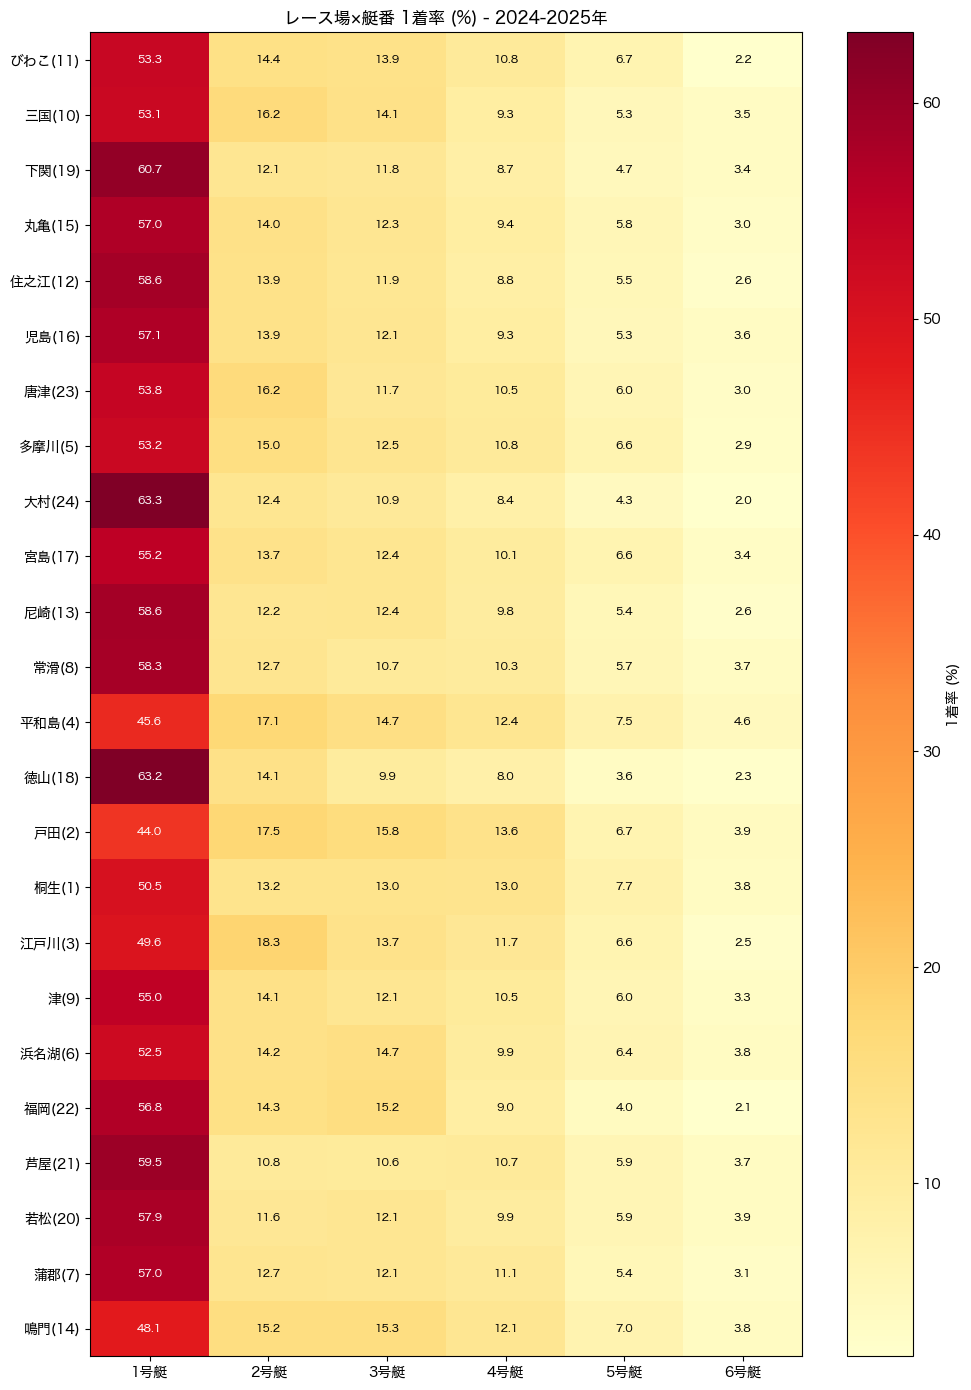

In [18]:
# ヒートマップで可視化
fig, ax = plt.subplots(figsize=(10, 14))

plot_data = win_rate_matrix[list(range(1, 7))].copy() * 100
plot_data.index = [f'{STADIUM_CODE_TO_NAME.get(i, i)}({i})' for i in plot_data.index]
plot_data = plot_data.sort_index()

im = ax.imshow(plot_data.values, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(6))
ax.set_xticklabels([f'{i}号艇' for i in range(1, 7)])
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data.index)

# 数値をセル内に表示
for i in range(len(plot_data)):
    for j in range(6):
        val = plot_data.values[i, j]
        color = 'white' if val > 40 else 'black'
        ax.text(j, i, f'{val:.1f}', ha='center', va='center', color=color, fontsize=8)

ax.set_title('レース場×艇番 1着率 (%) - 2024-2025年')
plt.colorbar(im, ax=ax, label='1着率 (%)')
plt.tight_layout()
plt.show()

In [19]:
# データ駆動のイン有利度マップを作成
# 方法: 各レース場の1号艇勝率を0-5のスケールにマッピング

def create_stadium_advantage_map(win_rate_matrix):
    """レース場×枠番の勝率からイン有利度マップを生成"""
    advantage_map = {}
    numeric_cols = [c for c in win_rate_matrix.columns if isinstance(c, (int, np.integer))]
    for stadium_code in win_rate_matrix.index:
        rates = win_rate_matrix.loc[stadium_code, numeric_cols].astype(float)
        # 0-5にスケーリング（最大勝率の枠=5、最小勝率の枠=0）
        min_rate = rates.min()
        max_rate = rates.max()
        rate_range = max_rate - min_rate
        if rate_range > 0:
            scaled = ((rates - min_rate) / rate_range * 5).round(2)
        else:
            scaled = pd.Series([2.5] * 6, index=rates.index)
        advantage_map[int(stadium_code)] = dict(zip(range(1, 7), scaled.values))
    return advantage_map

stadium_advantage_map = create_stadium_advantage_map(win_rate_matrix)

print('=== データ駆動イン有利度マップ ===')
print(f'現行固定マップ: {{1: 5, 2: 3, 3: 2, 4: 1, 5: 0, 6: 0}}')
print()
for code in sorted(stadium_advantage_map.keys()):
    name = STADIUM_CODE_TO_NAME[code]
    vals = stadium_advantage_map[code]
    print(f'  場{code:2d}（{name:4s}）: {{{1}: {vals[1]:.1f}, {2}: {vals[2]:.1f}, {3}: {vals[3]:.1f}, '
          f'{4}: {vals[4]:.1f}, {5}: {vals[5]:.1f}, {6}: {vals[6]:.1f}}}')

=== データ駆動イン有利度マップ ===
現行固定マップ: {1: 5, 2: 3, 3: 2, 4: 1, 5: 0, 6: 0}

  場 1（桐生  ）: {1: 5.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.4, 6: 0.0}
  場 2（戸田  ）: {1: 5.0, 2: 1.7, 3: 1.5, 4: 1.2, 5: 0.3, 6: 0.0}
  場 3（江戸川 ）: {1: 5.0, 2: 1.7, 3: 1.2, 4: 1.0, 5: 0.4, 6: 0.0}
  場 4（平和島 ）: {1: 5.0, 2: 1.5, 3: 1.2, 4: 0.9, 5: 0.3, 6: 0.0}
  場 5（多摩川 ）: {1: 5.0, 2: 1.2, 3: 1.0, 4: 0.8, 5: 0.4, 6: 0.0}
  場 6（浜名湖 ）: {1: 5.0, 2: 1.1, 3: 1.1, 4: 0.6, 5: 0.3, 6: 0.0}
  場 7（蒲郡  ）: {1: 5.0, 2: 0.9, 3: 0.8, 4: 0.7, 5: 0.2, 6: 0.0}
  場 8（常滑  ）: {1: 5.0, 2: 0.8, 3: 0.6, 4: 0.6, 5: 0.2, 6: 0.0}
  場 9（津   ）: {1: 5.0, 2: 1.1, 3: 0.9, 4: 0.7, 5: 0.3, 6: 0.0}
  場10（三国  ）: {1: 5.0, 2: 1.3, 3: 1.1, 4: 0.6, 5: 0.2, 6: 0.0}
  場11（びわこ ）: {1: 5.0, 2: 1.2, 3: 1.1, 4: 0.8, 5: 0.5, 6: 0.0}
  場12（住之江 ）: {1: 5.0, 2: 1.0, 3: 0.8, 4: 0.6, 5: 0.3, 6: 0.0}
  場13（尼崎  ）: {1: 5.0, 2: 0.8, 3: 0.9, 4: 0.6, 5: 0.2, 6: 0.0}
  場14（鳴門  ）: {1: 5.0, 2: 1.3, 3: 1.3, 4: 0.9, 5: 0.4, 6: 0.0}
  場15（丸亀  ）: {1: 5.0, 2: 1.0, 3: 0.9, 4: 0.6, 5: 0.3, 6: 0.0}
 

In [20]:
# 現行固定マップ vs データ駆動マップの比較
current_map = {1: 5, 2: 3, 3: 2, 4: 1, 5: 0, 6: 0}

print('=== 固定マップとの乖離が大きいレース場 ===')
deviations = []
for code, adv_map in stadium_advantage_map.items():
    name = STADIUM_CODE_TO_NAME[code]
    total_dev = sum(abs(adv_map[k] - current_map[k]) for k in range(1, 7))
    deviations.append({'場コード': code, '場名': name, '総乖離': round(total_dev, 2),
                       '1号艇有利度': adv_map[1], '固定値': current_map[1]})

dev_df = pd.DataFrame(deviations).sort_values('総乖離', ascending=False)
print(dev_df.to_string(index=False))

=== 固定マップとの乖離が大きいレース場 ===
 場コード  場名  総乖離  1号艇有利度  固定値
   21  芦屋 4.31     5.0    5
   20  若松 4.16     5.0    5
   19  下関 4.16     5.0    5
    8  常滑 4.11     5.0    5
   24  大村 4.09     5.0    5
   18  徳山 4.04     5.0    5
   13  尼崎 3.89     5.0    5
   16  児島 3.87     5.0    5
   12 住之江 3.87     5.0    5
   17  宮島 3.80     5.0    5
   15  丸亀 3.78     5.0    5
    7  蒲郡 3.76     5.0    5
    9   津 3.65     5.0    5
    1  桐生 3.45     5.0    5
    6 浜名湖 3.45     5.0    5
    5 多摩川 3.42     5.0    5
   23  唐津 3.39     5.0    5
   11 びわこ 3.26     5.0    5
   10  三国 3.24     5.0    5
   22  福岡 3.22     5.0    5
   14  鳴門 2.84     5.0    5
    4 平和島 2.63     5.0    5
    3 江戸川 2.60     5.0    5
    2  戸田 2.38     5.0    5


## 3. 日次数（節の何日目か）の影響分析

`日次数`は現在`exclude_cols`で除外されている。節の進行日ごとの予測精度を検証する。

In [21]:
import re

def extract_day_number(day_str):
    """'第N日' から N を抽出"""
    if pd.isna(day_str):
        return np.nan
    match = re.search(r'(\d+)', str(day_str))
    return int(match.group(1)) if match else np.nan

# programsデータの日次分布を確認
programs_dfs = []
for year in ['2025']:
    for month in range(1, 13):
        month_str = f'{month:02d}'
        prog_dir = repo_root / 'data' / 'programs' / year / month_str
        if not prog_dir.exists():
            continue
        for f in sorted(prog_dir.glob('*.csv')):
            try:
                df = pd.read_csv(f, dtype={'レースコード': str})
                programs_dfs.append(df)
            except Exception:
                pass

programs_2025 = pd.concat(programs_dfs, ignore_index=True)
programs_2025['日次数'] = programs_2025['日次'].apply(extract_day_number)

print('=== 日次数の分布（2025年） ===')
print(programs_2025['日次数'].value_counts().sort_index())

=== 日次数の分布（2025年） ===
日次数
1     9535
2    10212
3    10111
4     9998
5     8240
6     6360
7      357
Name: count, dtype: int64


In [22]:
# 結果データとマージして、日次数ごとの1号艇勝率を確認
# programs（ワイド）のレース情報とresultsをレースコードで結合

prog_race_info = programs_2025[['レースコード', '日次数']].copy()

# 2025年の結果を読み込み
results_2025_dfs = []
for month in range(1, 13):
    month_str = f'{month:02d}'
    res_dir = repo_root / 'data' / 'results' / '2025' / month_str
    if not res_dir.exists():
        continue
    for f in sorted(res_dir.glob('*.csv')):
        try:
            df = pd.read_csv(f, dtype={'レースコード': str})
            results_2025_dfs.append(df)
        except Exception:
            pass

if results_2025_dfs:
    results_2025 = pd.concat(results_2025_dfs, ignore_index=True)
    results_2025_long = reshape_results(results_2025)
    results_2025_long['艇番'] = pd.to_numeric(results_2025_long['艇番'], errors='coerce')
    results_2025_long['is_1着'] = (results_2025_long['着順'] == 1).astype(int)
    
    # 日次数をマージ
    results_with_day = results_2025_long.merge(prog_race_info, on='レースコード', how='left')
    
    # 日次数ごとの1号艇勝率
    day_analysis = results_with_day[results_with_day['艇番'] == 1].groupby('日次数').agg(
        レース数=('is_1着', 'count'),
        _1着率=('is_1着', 'mean'),
    ).reset_index()
    day_analysis['1号艇勝率'] = (day_analysis['_1着率'] * 100).round(1)
    
    print('=== 日次数ごとの1号艇勝率（2025年） ===')
    print(day_analysis[['日次数', 'レース数', '1号艇勝率']].to_string(index=False))
    
    # 日次数ごとの全体的な1着予測難易度（エントロピー等）
    day_win_dist = results_with_day[results_with_day['着順'] == 1].groupby(['日次数', '艇番']).size().unstack(fill_value=0)
    day_win_dist_pct = day_win_dist.div(day_win_dist.sum(axis=1), axis=0) * 100
    print('\n=== 日次数×艇番 1着率(%) ===')
    print(day_win_dist_pct.round(1).to_string())
else:
    print('2025年の結果データなし')

=== 日次数ごとの1号艇勝率（2025年） ===
 日次数  レース数  1号艇勝率
 1.0  7577   52.0
 2.0  7744   52.1
 3.0  7613   51.4
 4.0  7592   54.6
 5.0  6372   58.6
 6.0  5028   58.1
 7.0   238   58.0

=== 日次数×艇番 1着率(%) ===
艇番    1.0   2.0   3.0   4.0  5.0  6.0
日次数                                  
1.0  51.5  15.0  13.1  11.1  6.2  3.1
2.0  51.4  14.4  13.8  10.4  6.3  3.8
3.0  50.7  15.6  13.7  10.7  6.3  3.0
4.0  53.8  14.0  12.7  10.5  6.1  2.8
5.0  57.9  11.3  11.9   9.5  6.1  3.3
6.0  57.5  12.6  11.7  10.1  5.2  3.0
7.0  58.0  17.2  11.8   5.5  5.0  2.5


In [23]:
# confirmデータに日次数を付けて、日次数ごとの予測精度を確認
# confirmのレースコードからprogramsの日次を取得

# 2026年のprogramsから日次数を抽出
prog_2026_dfs = []
for m in ['01', '02']:
    prog_dir = repo_root / 'data' / 'programs' / '2026' / m
    if not prog_dir.exists():
        continue
    for f in sorted(prog_dir.glob('*.csv')):
        try:
            df = pd.read_csv(f, dtype={'レースコード': str})
            prog_2026_dfs.append(df)
        except Exception:
            pass

if prog_2026_dfs:
    prog_2026 = pd.concat(prog_2026_dfs, ignore_index=True)
    prog_2026['日次数'] = prog_2026['日次'].apply(extract_day_number)
    
    confirm_with_day = confirm.merge(
        prog_2026[['レースコード', '日次数']].drop_duplicates(),
        on='レースコード', how='left'
    )
    
    day_accuracy = confirm_with_day.groupby('日次数').agg(
        レース数=('1着的中', 'count'),
        _1着的中数=('1着的中', lambda x: (x == '○').sum()),
    ).reset_index()
    day_accuracy['1着的中率'] = (pd.to_numeric(day_accuracy['_1着的中数']) / pd.to_numeric(day_accuracy['レース数']) * 100).round(1)
    
    print('=== 日次数ごとの予測的中率（2026年1-2月） ===')
    print(day_accuracy[['日次数', 'レース数', '1着的中率']].to_string(index=False))

=== 日次数ごとの予測的中率（2026年1-2月） ===
 日次数  レース数  1着的中率
   1   465   44.9
   2   463   42.5
   3   475   41.3
   4   414   46.4
   5   272   53.3
   6    60   61.7


## 4. NaN処理の改善検討

現在のNaN処理（median/0埋め）の問題点と改善案を検証する。

In [24]:
# 今節データのNaN状況を確認
# 日次数=1（初日）の選手は今節成績が全てNaN

prog_long_2026 = reshape_programs(prog_2026)
prog_long_2026['日次数'] = prog_long_2026['日次'].apply(extract_day_number)
prog_long_2026 = compute_konseki_features(prog_long_2026)

konseki_cols = ['今節_平均着順', '今節_1着回数', '今節_3連対率', '今節_出走回数', '今節_最新着順']

print('=== 日次数ごとの今節成績NaN率 ===')
for day in sorted(prog_long_2026['日次数'].dropna().unique()):
    subset = prog_long_2026[prog_long_2026['日次数'] == day]
    print(f'\n第{int(day)}日 ({len(subset)}選手):')
    for col in konseki_cols:
        nan_rate = subset[col].isna().mean() * 100
        print(f'  {col}: NaN率 {nan_rate:.1f}%')

=== 日次数ごとの今節成績NaN率 ===

第1日 (7098選手):
  今節_平均着順: NaN率 85.4%
  今節_1着回数: NaN率 0.0%
  今節_3連対率: NaN率 85.4%
  今節_出走回数: NaN率 0.0%
  今節_最新着順: NaN率 85.4%

第2日 (6948選手):
  今節_平均着順: NaN率 47.2%
  今節_1着回数: NaN率 0.0%
  今節_3連対率: NaN率 47.2%
  今節_出走回数: NaN率 0.0%
  今節_最新着順: NaN率 47.2%

第3日 (7452選手):
  今節_平均着順: NaN率 8.0%
  今節_1着回数: NaN率 0.0%
  今節_3連対率: NaN率 8.0%
  今節_出走回数: NaN率 0.0%
  今節_最新着順: NaN率 8.0%

第4日 (7260選手):
  今節_平均着順: NaN率 4.9%
  今節_1着回数: NaN率 0.0%
  今節_3連対率: NaN率 4.9%
  今節_出走回数: NaN率 0.0%
  今節_最新着順: NaN率 4.9%

第5日 (5538選手):
  今節_平均着順: NaN率 5.4%
  今節_1着回数: NaN率 0.0%
  今節_3連対率: NaN率 5.4%
  今節_出走回数: NaN率 0.0%
  今節_最新着順: NaN率 5.4%

第6日 (4668選手):
  今節_平均着順: NaN率 4.2%
  今節_1着回数: NaN率 0.0%
  今節_3連対率: NaN率 4.2%
  今節_出走回数: NaN率 0.0%
  今節_最新着順: NaN率 4.2%

第7日 (144選手):
  今節_平均着順: NaN率 20.8%
  今節_1着回数: NaN率 0.0%
  今節_3連対率: NaN率 20.8%
  今節_出走回数: NaN率 0.0%
  今節_最新着順: NaN率 20.8%


In [25]:
# 履歴統計のNaN状況を確認
# player_stats と stadium_player_stats のカバー率

player_stats = models.get('_player_stats')
stadium_player_stats = models.get('_stadium_player_stats')

if player_stats is not None:
    print('=== _player_stats ===')
    print(f'選手数: {len(player_stats)}')
    print(f'カラム: {list(player_stats.columns)}')
    print(f'NaN率:')
    for col in player_stats.columns:
        if col != '登録番号':
            nan_rate = player_stats[col].isna().mean() * 100
            print(f'  {col}: {nan_rate:.1f}%')

if stadium_player_stats is not None:
    print(f'\n=== _stadium_player_stats ===')
    print(f'行数: {len(stadium_player_stats)}')
    print(f'カラム: {list(stadium_player_stats.columns)}')
    print(f'NaN率:')
    for col in stadium_player_stats.columns:
        if col not in ['登録番号', 'レース場']:
            nan_rate = stadium_player_stats[col].isna().mean() * 100
            print(f'  {col}: {nan_rate:.1f}%')

=== _player_stats ===
選手数: 2064
カラム: ['登録番号', '履歴_平均着順', '履歴_1着率', '履歴_出走回数', 'イン1着率']
NaN率:
  履歴_平均着順: 0.0%
  履歴_1着率: 0.0%
  履歴_出走回数: 0.0%
  イン1着率: 4.9%

=== _stadium_player_stats ===
行数: 43754
カラム: ['登録番号', 'レース場', '当場_平均着順', '当場_1着率', '当場_出走回数']
NaN率:
  当場_平均着順: 0.0%
  当場_1着率: 0.0%
  当場_出走回数: 0.0%


In [26]:
# 2026/02/01のデータで実際のNaN→fill後の値を確認
first_stadium_key = [k for k in models.keys() if isinstance(k, (int, np.integer))][0]
feature_cols = models[first_stadium_key]['features']

X_before = pd.DataFrame(index=merged.index)
for col in feature_cols:
    if col in merged.columns:
        X_before[col] = pd.to_numeric(merged[col], errors='coerce')
    else:
        X_before[col] = np.nan

print('=== 特徴量のNaN率（fill前） ===')
nan_rates = X_before.isna().mean().sort_values(ascending=False)
for col, rate in nan_rates.items():
    if rate > 0:
        print(f'  {col}: {rate*100:.1f}% ({X_before[col].isna().sum()}/{len(X_before)})')

print(f'\nNaN率 > 0 の特徴量数: {(nan_rates > 0).sum()}/{len(feature_cols)}')


=== 特徴量のNaN率（fill前） ===
  体重調整(kg): 100.0% (996/996)
  体重(kg): 100.0% (996/996)
  今節_最新着順: 32.0% (319/996)
  今節_平均着順: 32.0% (319/996)
  今節_3連対率: 32.0% (319/996)
  当地2連対率: 12.8% (127/996)
  当地勝率_偏差: 8.8% (88/996)
  当地勝率: 8.8% (88/996)
  イン1着率: 5.8% (58/996)
  当場_平均着順: 5.3% (53/996)
  当場_出走回数: 5.3% (53/996)
  当場_1着率: 5.3% (53/996)
  履歴_1着率: 1.9% (19/996)
  履歴_平均着順: 1.9% (19/996)
  履歴_出走回数: 1.9% (19/996)
  全国2連対率: 1.3% (13/996)
  全国勝率: 0.2% (2/996)
  全国勝率_偏差: 0.2% (2/996)
  全国勝率_最大差: 0.2% (2/996)

NaN率 > 0 の特徴量数: 19/33


In [27]:
# NaN処理の改善案: 0ではなく適切なデフォルト値を使用

def prepare_features_improved(data, feature_cols):
    """改善版NaN処理: 履歴統計のNaNには全体平均、今節は明示的フラグ"""
    X = pd.DataFrame(index=data.index)
    for col in feature_cols:
        if col in data.columns:
            X[col] = pd.to_numeric(data[col], errors='coerce')
        else:
            X[col] = np.nan
    
    # 改善: 着順系のNaNは3.5（中央値）で埋める
    rank_cols = ['履歴_平均着順', '当場_平均着順', '今節_平均着順', '今節_最新着順']
    for col in rank_cols:
        if col in X.columns:
            X[col] = X[col].fillna(3.5)
    
    # 改善: 率系のNaNは0.5（50%基準）で埋める
    rate_cols = ['履歴_1着率', '当場_1着率', '今節_3連対率', 'イン1着率']
    for col in rate_cols:
        if col in X.columns:
            X[col] = X[col].fillna(X[col].median() if X[col].notna().any() else 0.167)
    
    # 残りは従来通りmedian/0
    for col in X.columns:
        if X[col].isna().any():
            if X[col].notna().any():
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(0)
    return X

# 比較: 現行 vs 改善版
X_current = prepare_features(merged, feature_cols)
X_improved = prepare_features_improved(merged, feature_cols)

print('=== NaN処理の比較（fill後の値の違い） ===')
for col in feature_cols:
    diff = (X_current[col] - X_improved[col]).abs()
    if diff.sum() > 0:
        n_diff = (diff > 0.001).sum()
        print(f'  {col}: {n_diff}行で差異あり, 最大差={diff.max():.4f}')

=== NaN処理の比較（fill後の値の違い） ===
  今節_平均着順: 319行で差異あり, 最大差=0.1667
  今節_最新着順: 319行で差異あり, 最大差=0.5000
  履歴_平均着順: 19行で差異あり, 最大差=0.0886
  当場_平均着順: 53行で差異あり, 最大差=0.0556


## 5. 未使用モデル削除の確認

`program_models.pkl` と `stadium_models.pkl` がどこからも参照されていないことを確認する。

In [28]:
import os

# モデルファイルのサイズ確認
models_dir = repo_root / 'models'
print('=== models/ ディレクトリ ===')
total_size = 0
for f in sorted(models_dir.iterdir()):
    size_mb = f.stat().st_size / (1024 * 1024)
    total_size += size_mb
    print(f'  {f.name}: {size_mb:.1f} MB')
print(f'  合計: {total_size:.1f} MB')

=== models/ ディレクトリ ===
  .gitattributes: 0.0 MB
  preview_models.pkl: 290.8 MB
  program_models.pkl: 18.0 MB
  program_models_v2.pkl: 30.7 MB
  stadium_models.pkl: 15.1 MB
  weather_stats.json: 0.0 MB
  合計: 354.7 MB


In [29]:
# scriptsディレクトリ内でモデルファイル名を検索
import subprocess

scripts_dir = repo_root / 'scripts'
for model_name in ['program_models.pkl', 'stadium_models.pkl', 'program_models_v2.pkl', 'preview_models.pkl']:
    result = subprocess.run(
        ['grep', '-r', model_name, str(scripts_dir)],
        capture_output=True, text=True
    )
    refs = [line for line in result.stdout.strip().split('\n') if line]
    status = '使用中' if refs else '未使用'
    print(f'\n{model_name}: {status}')
    for ref in refs:
        print(f'  {ref}')


program_models.pkl: 使用中
  Binary file /Users/mahiguch/dev/boatrace/data/scripts/__pycache__/estimate.cpython-311.pyc matches
  /Users/mahiguch/dev/boatrace/data/scripts/estimate.py:models/program_models.pkl.



stadium_models.pkl: 未使用



program_models_v2.pkl: 使用中
  /Users/mahiguch/dev/boatrace/data/scripts/estimate.py:    model_path = repo_root / 'models' / 'program_models_v2.pkl'

preview_models.pkl: 使用中
  /Users/mahiguch/dev/boatrace/data/scripts/prediction-preview.py:models/preview_models.pkl.
  /Users/mahiguch/dev/boatrace/data/scripts/prediction-preview.py:    model_path = repo_root / 'models' / 'preview_models.pkl'


## 7. 低的中率レース場の深掘り調査

「まとめ」で `要調査` とした低的中率レース場の問題を、以下の観点で深掘りする。

1. **ranking_model vs classifier のスコア内訳** — どちらのモデルが1号艇を過小評価しているか
2. **特徴量重要度の比較** — 問題レース場と正常レース場でモデルの判断根拠がどう異なるか
3. **学習データの偏り** — 問題レース場の学習データ量・1号艇勝率に偏りがないか
4. **直前情報（preview）コースデータの検証** — 全艇コース=1 の原因特定
5. **特徴量分布の異常検出** — 問題レース場で NaN 率やゼロ埋め率が高くないか

In [30]:
# 7.1 ranking_model vs classifier のスコア内訳分析
# 問題レース場と正常レース場でどちらのモデルが1号艇を過小評価しているか

from collections import defaultdict

problem_codes = [20, 22, 2, 21, 11]  # 若松, 福岡, 戸田, 芦屋, びわこ
normal_codes = [24, 15, 17, 12, 10]   # 大村, 丸亀, 宮島, 住之江, 三国

ensemble_weights = models.get('_ensemble_weights', (0.7, 0.2, 0.1))
w_rank, w_cls, w_gbc = ensemble_weights

def load_and_merge_day(y, m, d):
    """1日分のデータを読み込み・マージして特徴量生成まで行う（Cell 17 準拠）"""
    prog_path = repo_root / 'data' / 'programs' / y / m / f'{d}.csv'
    prev_path = repo_root / 'data' / 'prediction-preview' / y / m / f'{d}.csv'
    if not prog_path.exists():
        return None
    programs_df = pd.read_csv(prog_path, dtype={'レースコード': str})
    pl = reshape_programs(programs_df)
    previews_df = pd.read_csv(prev_path, dtype={'レースコード': str}) if prev_path.exists() else None
    pv = reshape_previews(previews_df) if previews_df is not None else None
    mg = pl.copy()
    if pv is not None:
        preview_cols = ['レースコード', '艇番', 'コース', 'スタート展示', 'チルト調整', '展示タイム']
        existing_cols = [c for c in preview_cols if c in pv.columns]
        mg = mg.merge(pv[existing_cols], left_on=['レースコード', '枠'], right_on=['レースコード', '艇番'], how='left', suffixes=('', '_preview'))
    mg['枠'] = mg.get('枠', pd.Series(dtype=int))
    mg['艇番'] = mg['枠']
    if '日次' in mg.columns:
        mg['日次数'] = mg['日次'].apply(extract_day_number)
    mg = compute_konseki_features(mg)
    mg = compute_relative_features(mg)
    mg = compute_course_features(mg)
    if '級別' in mg.columns:
        mg['級別_encoded'] = mg['級別'].map({'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3}).fillna(3)
    mg['レース場_num'] = mg['レース場'].apply(lambda x: STADIUM_NAME_TO_CODE.get(str(x).strip()) if pd.notna(x) else np.nan)
    mg['レース場_num'] = pd.to_numeric(mg['レース場_num'], errors='coerce')
    ps = models.get('_player_stats')
    sps = models.get('_stadium_player_stats')
    if ps is not None and '登録番号' in mg.columns:
        mg['登録番号'] = pd.to_numeric(mg['登録番号'], errors='coerce')
        mg = mg.merge(ps, on='登録番号', how='left')
    if sps is not None and '登録番号' in mg.columns:
        mg_key = mg['レース場_num'].astype('Int64')
        mg_tmp = mg.copy()
        mg_tmp['_merge_stadium'] = mg_key
        sps_tmp = sps.copy()
        sps_tmp['_merge_stadium'] = sps_tmp['レース場']
        mg = mg_tmp.merge(sps_tmp, left_on=['登録番号', '_merge_stadium'], right_on=['登録番号', '_merge_stadium'], how='left', suffixes=('', '_stadium_stat'))
        mg = mg.drop(columns=['_merge_stadium'], errors='ignore')
    return mg

def analyze_scores_for_stadiums(stadium_codes, merged_data, models_dict, label):
    """レース場群ごとに rank/cls スコアの1号艇ランクを集計"""
    results = defaultdict(list)
    for race_code in merged_data['レースコード'].unique():
        race = merged_data[merged_data['レースコード'] == race_code]
        sc = race['レース場_num'].iloc[0]
        if pd.isna(sc) or int(sc) not in stadium_codes or int(sc) not in models_dict:
            continue
        sc = int(sc)
        mi = models_dict[sc]
        X = prepare_features(race, mi['features'])
        n = len(X)
        if n < 2:
            continue

        # rank scores
        rank_s = mi['ranking_model'].predict(X) if 'ranking_model' in mi else np.zeros(n)
        # cls scores
        cls_s = np.zeros(n)
        if 'model' in mi and 'scaler' in mi:
            try:
                X_sc = mi['scaler'].transform(X)
                proba = mi['model'].predict_proba(X_sc)
                cls_s = -(proba @ mi['model'].classes_.astype(float))
            except Exception:
                pass

        boats = race['艇番'].values
        boat1_idx = np.where(boats == 1)[0]
        if len(boat1_idx) == 0:
            continue
        b1 = boat1_idx[0]

        rank_order = np.argsort(-rank_s)
        cls_order = np.argsort(-cls_s)
        rank_pos = np.where(rank_order == b1)[0][0] + 1
        cls_pos = np.where(cls_order == b1)[0][0] + 1

        # アンサンブル (min-max正規化)
        rank_n = rank_s.copy()
        cls_n = cls_s.copy()
        for arr in [rank_n, cls_n]:
            vmin, vmax = arr.min(), arr.max()
            if vmax > vmin:
                arr[:] = (arr - vmin) / (vmax - vmin)
            else:
                arr[:] = 0.5
        ens = w_rank * rank_n + (w_cls + w_gbc) * cls_n
        ens_order = np.argsort(-ens)
        ens_pos = np.where(ens_order == b1)[0][0] + 1

        results['stadium'].append(STADIUM_CODE_TO_NAME[sc])
        results['rank_pos'].append(rank_pos)
        results['cls_pos'].append(cls_pos)
        results['ens_pos'].append(ens_pos)

    df = pd.DataFrame(results)
    if df.empty:
        print(f'{label}: データなし')
        return df
    summary = df.groupby('stadium').agg(
        レース数=('rank_pos', 'count'),
        rank_1号艇平均順位=('rank_pos', 'mean'),
        cls_1号艇平均順位=('cls_pos', 'mean'),
        ens_1号艇平均順位=('ens_pos', 'mean'),
        rank_1位率=('rank_pos', lambda x: (x == 1).mean() * 100),
        cls_1位率=('cls_pos', lambda x: (x == 1).mean() * 100),
        ens_1位率=('ens_pos', lambda x: (x == 1).mean() * 100),
    ).round(1)
    print(f'=== {label} ===')
    print(summary.to_string())
    return summary

# 複数日のデータで分析
analyze_dates = [('2026', '02', '01'), ('2026', '02', '02'), ('2026', '01', '25'), ('2026', '01', '26')]
all_merged = []
for y, m, d in analyze_dates:
    mg = load_and_merge_day(y, m, d)
    if mg is not None and not mg.empty:
        all_merged.append(mg)

merged_all = pd.concat(all_merged, ignore_index=True)
print(f'分析対象: {len(merged_all)} 行, {merged_all["レースコード"].nunique()} レース\n')

prob_summary = analyze_scores_for_stadiums(problem_codes, merged_all, models, '低的中率レース場')
print()
norm_summary = analyze_scores_for_stadiums(normal_codes, merged_all, models, '高的中率レース場')


分析対象: 4080 行, 680 レース



/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

=== 低的中率レース場 ===
         レース数  rank_1号艇平均順位  cls_1号艇平均順位  ens_1号艇平均順位  rank_1位率  cls_1位率  ens_1位率
stadium                                                                          
びわこ        11           2.1          2.2          2.2      63.6     63.6     63.6
戸田         24           2.6          2.5          2.6      33.3     33.3     33.3
福岡         12           1.4          1.6          1.5      83.3     75.0     75.0
芦屋         21           1.2          1.2          1.2      90.5     95.2     90.5
若松         12           1.0          1.2          1.0     100.0     83.3    100.0



/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mahiguch/dev/boatrace/data/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

=== 高的中率レース場 ===
         レース数  rank_1号艇平均順位  cls_1号艇平均順位  ens_1号艇平均順位  rank_1位率  cls_1位率  ens_1位率
stadium                                                                          
三国         48           1.7          1.8          1.7      66.7     60.4     66.7
住之江        24           1.2          1.3          1.2      95.8     79.2     95.8
大村         24           1.3          1.4          1.3      83.3     83.3     83.3
宮島         24           1.1          1.5          1.2      91.7     75.0     91.7


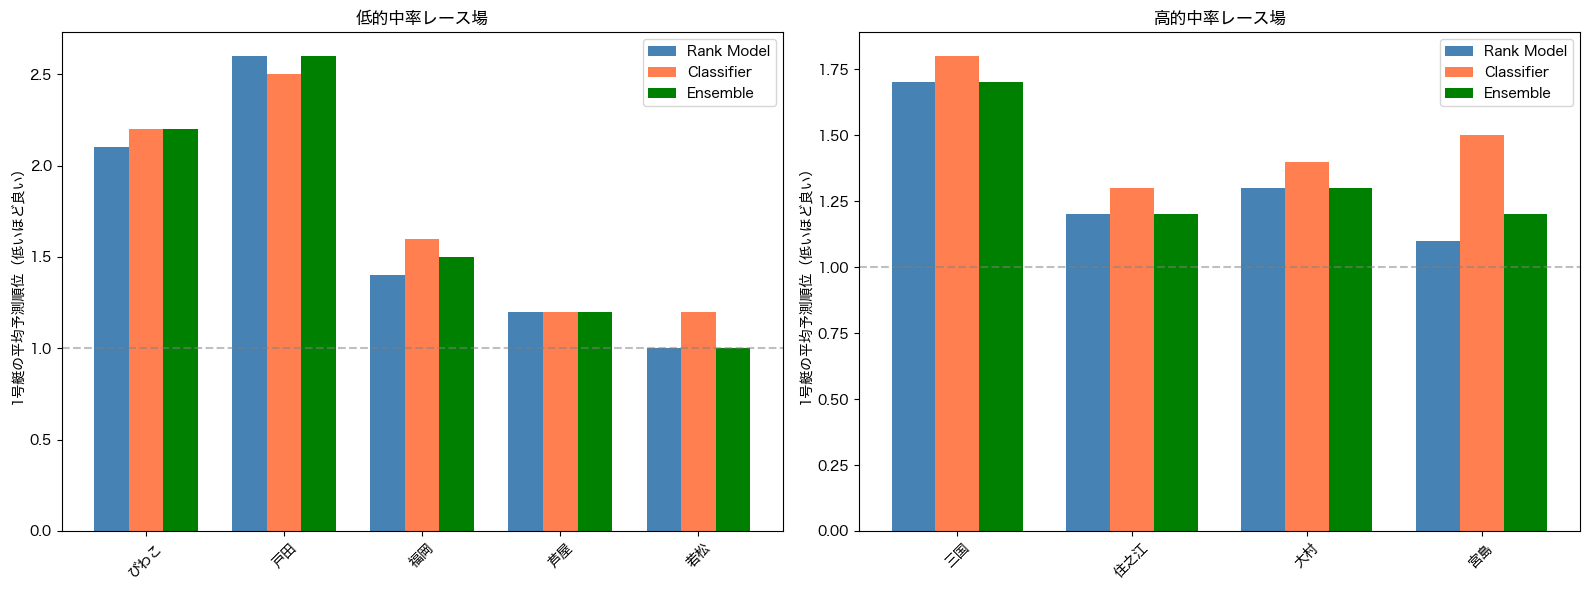

In [31]:
# 7.1b 可視化: 問題 vs 正常レース場の1号艇評価
if not prob_summary.empty and not norm_summary.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 左: 1号艇の平均順位
    ax = axes[0]
    x = np.arange(len(prob_summary))
    w = 0.25
    ax.bar(x - w, prob_summary['rank_1号艇平均順位'], w, label='Rank Model', color='steelblue')
    ax.bar(x, prob_summary['cls_1号艇平均順位'], w, label='Classifier', color='coral')
    ax.bar(x + w, prob_summary['ens_1号艇平均順位'], w, label='Ensemble', color='green')
    ax.set_xticks(x)
    ax.set_xticklabels(prob_summary.index, rotation=45)
    ax.set_ylabel('1号艇の平均予測順位（低いほど良い）')
    ax.set_title('低的中率レース場')
    ax.legend()
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)

    ax = axes[1]
    x = np.arange(len(norm_summary))
    ax.bar(x - w, norm_summary['rank_1号艇平均順位'], w, label='Rank Model', color='steelblue')
    ax.bar(x, norm_summary['cls_1号艇平均順位'], w, label='Classifier', color='coral')
    ax.bar(x + w, norm_summary['ens_1号艇平均順位'], w, label='Ensemble', color='green')
    ax.set_xticks(x)
    ax.set_xticklabels(norm_summary.index, rotation=45)
    ax.set_ylabel('1号艇の平均予測順位（低いほど良い）')
    ax.set_title('高的中率レース場')
    ax.legend()
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

In [32]:
# 7.2 特徴量重要度の比較: 問題レース場 vs 正常レース場

def get_feature_importance(models_dict, stadium_code):
    """レース場モデルの特徴量重要度を取得"""
    if stadium_code not in models_dict:
        return None
    mi = models_dict[stadium_code]
    features = mi['features']
    importances = {}
    if 'ranking_model' in mi:
        rank_imp = mi['ranking_model'].feature_importance(importance_type='gain')
        for f, imp in zip(features, rank_imp):
            importances[f] = importances.get(f, 0) + imp
    return importances

# 問題レース場 top-10 特徴量
print('=== 問題レース場の ranking_model 特徴量重要度 Top-10 ===')
for sc in problem_codes:
    imp = get_feature_importance(models, sc)
    if imp is None:
        print(f'{STADIUM_CODE_TO_NAME[sc]}: モデルなし')
        continue
    top10 = sorted(imp.items(), key=lambda x: -x[1])[:10]
    print(f'\n{STADIUM_CODE_TO_NAME[sc]}（場{sc}）:')
    for f, v in top10:
        print(f'  {f}: {v:.0f}')

print('\n=== 正常レース場の ranking_model 特徴量重要度 Top-10 ===')
for sc in normal_codes:
    imp = get_feature_importance(models, sc)
    if imp is None:
        print(f'{STADIUM_CODE_TO_NAME[sc]}: モデルなし')
        continue
    top10 = sorted(imp.items(), key=lambda x: -x[1])[:10]
    print(f'\n{STADIUM_CODE_TO_NAME[sc]}（場{sc}）:')
    for f, v in top10:
        print(f'  {f}: {v:.0f}')

=== 問題レース場の ranking_model 特徴量重要度 Top-10 ===

若松（場20）:
  コース: 217279
  イン有利度: 101100
  枠×全国勝率: 38992
  当場_1着率: 7926
  当場_平均着順: 7581
  展示タイム: 4707
  体重(kg): 3070
  全国勝率: 2181
  全国勝率_偏差: 2073
  スタート展示: 1516

福岡（場22）:
  コース: 66805
  イン有利度: 25207
  枠×全国勝率: 15375
  当場_1着率: 9640
  当場_平均着順: 2120
  体重(kg): 1911
  スタート展示: 1233
  展示タイム: 1146
  全国勝率_偏差: 707
  全国勝率: 624

戸田（場2）:
  コース: 161042
  全国勝率_偏差: 89921
  当場_1着率: 74596
  イン有利度: 73520
  全国勝率_最大差: 48005
  枠×全国勝率: 28775
  当場_平均着順: 23684
  履歴_1着率: 12679
  イン1着率: 7869
  モーター2連対率: 5631

芦屋（場21）:
  コース: 124088
  イン有利度: 47876
  枠×全国勝率: 21844
  当場_1着率: 8674
  展示タイム: 2044
  当場_平均着順: 1582
  体重(kg): 1373
  全国勝率: 1348
  スタート展示: 1193
  全国2連対率: 776

びわこ（場11）:
  コース: 132535
  イン有利度: 64422
  当場_1着率: 47483
  全国勝率_偏差: 29351
  枠×全国勝率: 22963
  当場_平均着順: 22268
  全国勝率_最大差: 9818
  全国勝率: 4229
  当地勝率_偏差: 1965
  履歴_平均着順: 1845

=== 正常レース場の ranking_model 特徴量重要度 Top-10 ===

大村（場24）:
  イン有利度: 283889
  コース: 191377
  枠×全国勝率: 50916
  全国勝率_偏差: 47795
  当場_1着率: 24957
  全国勝率_最大差: 

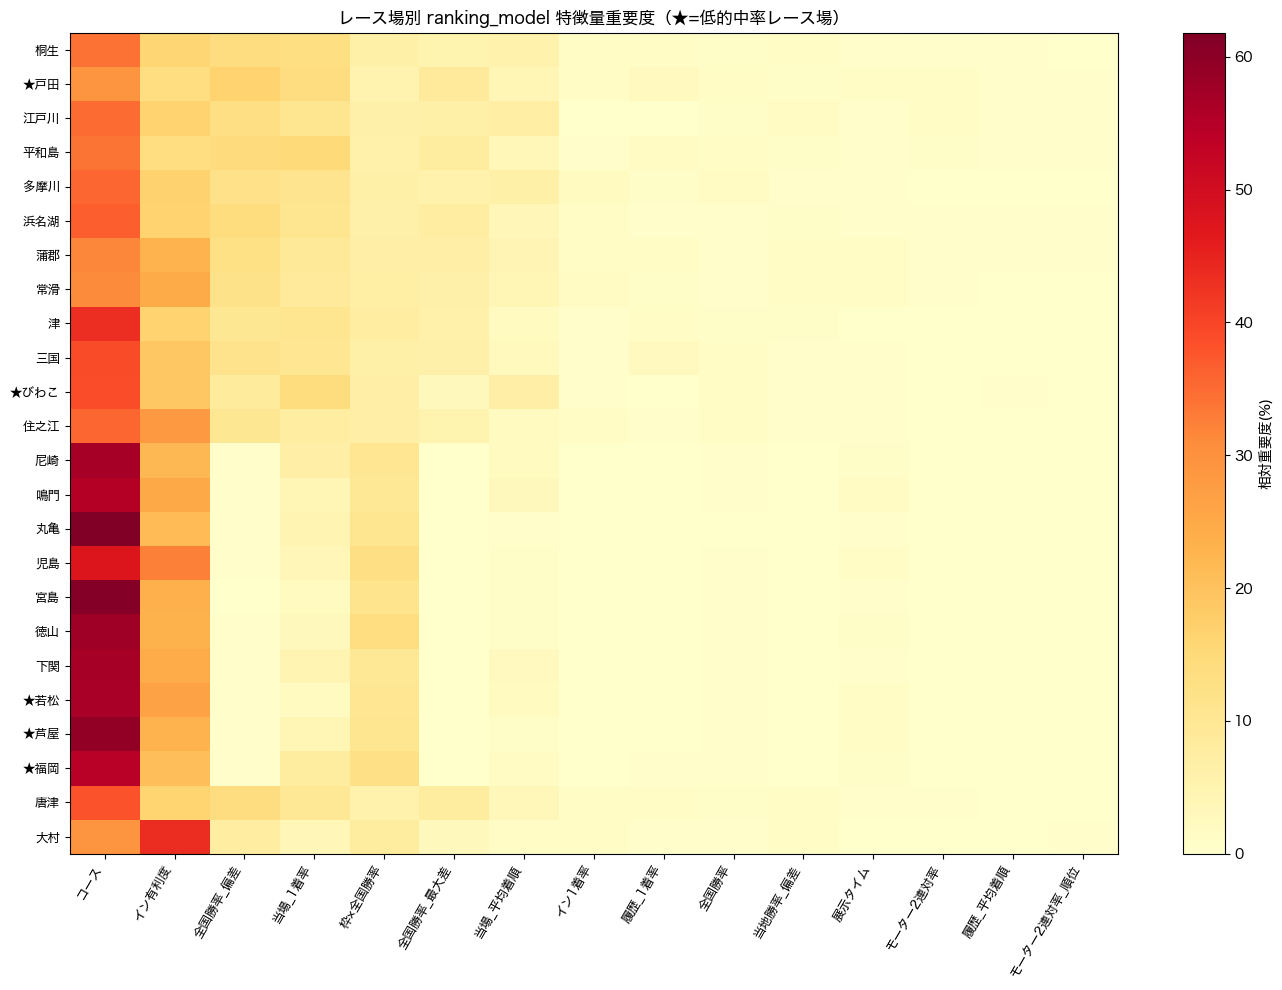

In [33]:
# 7.2b 特徴量重要度ヒートマップ: 全レース場比較

all_importances = {}
for sc in sorted(STADIUM_CODE_TO_NAME.keys()):
    imp = get_feature_importance(models, sc)
    if imp:
        all_importances[STADIUM_CODE_TO_NAME[sc]] = imp

imp_df = pd.DataFrame(all_importances).T
imp_df = imp_df.fillna(0)

# 全体平均の top-15 特徴量に絞る
top_features = imp_df.mean().nlargest(15).index.tolist()
imp_top = imp_df[top_features]

# 正規化（レース場ごとの相対重要度）
imp_norm = imp_top.div(imp_top.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(imp_norm.values, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=60, ha='right', fontsize=9)
ax.set_yticks(range(len(imp_norm)))
ylabels = [f'★{n}' if n in [STADIUM_CODE_TO_NAME[c] for c in problem_codes] else n for n in imp_norm.index]
ax.set_yticklabels(ylabels, fontsize=9)
plt.colorbar(im, ax=ax, label='相対重要度(%)')
ax.set_title('レース場別 ranking_model 特徴量重要度（★=低的中率レース場）')
plt.tight_layout()
plt.show()

In [34]:
# 7.3 学習データの偏り検証
# 各レース場の学習データ量と1号艇勝率を確認

# 2024-2025年の結果データ（既にresults_allに読み込み済み）からレース場別統計
results_long_all = reshape_results(results_all)
results_long_all['艇番'] = pd.to_numeric(results_long_all['艇番'], errors='coerce')
results_long_all['is_1着'] = (results_long_all['着順'] == 1).astype(int)
results_long_all['場コード'] = results_long_all['レースコード'].str[8:10].astype(int)

train_stats = results_long_all[results_long_all['艇番'] == 1].groupby('場コード').agg(
    学習レース数=('is_1着', 'count'),
    _1号艇勝率=('is_1着', 'mean'),
).reset_index()
train_stats['1号艇勝率'] = (train_stats['_1号艇勝率'] * 100).round(1)
train_stats['場名'] = train_stats['場コード'].map(STADIUM_CODE_TO_NAME)
train_stats['問題場'] = train_stats['場コード'].isin(problem_codes).map({True: '★', False: ''})

print('=== レース場別 学習データ統計（2024-2025年） ===')
print(train_stats[['場コード', '場名', '問題場', '学習レース数', '1号艇勝率']]
      .sort_values('1号艇勝率').to_string(index=False))

print(f'\n平均学習レース数: {train_stats["学習レース数"].mean():.0f}')
print(f'平均1号艇勝率: {train_stats["1号艇勝率"].mean():.1f}%')
print(f'\n問題場の平均学習レース数: {train_stats[train_stats["場コード"].isin(problem_codes)]["学習レース数"].mean():.0f}')
print(f'問題場の平均1号艇勝率: {train_stats[train_stats["場コード"].isin(problem_codes)]["1号艇勝率"].mean():.1f}%')
print(f'正常場の平均学習レース数: {train_stats[train_stats["場コード"].isin(normal_codes)]["学習レース数"].mean():.0f}')
print(f'正常場の平均1号艇勝率: {train_stats[train_stats["場コード"].isin(normal_codes)]["1号艇勝率"].mean():.1f}%')

=== レース場別 学習データ統計（2024-2025年） ===
 場コード  場名 問題場  学習レース数  1号艇勝率
    2  戸田   ★    4742   44.0
    4 平和島        4080   45.6
   14  鳴門        4305   48.1
    3 江戸川        4120   49.6
    1  桐生        4503   50.5
    6 浜名湖        4857   52.5
   10  三国        4540   53.1
    5 多摩川        4609   53.2
   11 びわこ   ★    4434   53.3
   23  唐津        4065   53.8
    9   津        4615   55.0
   17  宮島        4766   55.2
   22  福岡   ★    4494   56.8
   15  丸亀        4876   57.0
    7  蒲郡        4647   57.0
   16  児島        4178   57.1
   20  若松   ★    4467   57.9
    8  常滑        4838   58.3
   13  尼崎        4295   58.6
   12 住之江        4717   58.6
   21  芦屋   ★    4602   59.5
   19  下関        4529   60.7
   18  徳山        4082   63.2
   24  大村        4836   63.3

平均学習レース数: 4508
平均1号艇勝率: 55.1%

問題場の平均学習レース数: 4548
問題場の平均1号艇勝率: 54.3%
正常場の平均学習レース数: 4747
正常場の平均1号艇勝率: 57.4%


In [35]:
# 7.4 直前情報（preview）コースデータの検証
# 全艇コース=1 の原因を特定する

# (a) 元CSVの prediction-preview を確認
prev_dir = repo_root / 'data' / 'prediction-preview' / '2026' / '02'
prev_files = sorted(prev_dir.glob('*.csv')) if prev_dir.exists() else []
if prev_files:
    sample_prev = pd.read_csv(prev_files[0], dtype={'レースコード': str})
    print(f'=== prediction-preview 元CSV: {prev_files[0].name} ===')
    print(f'カラム数: {len(sample_prev.columns)}')
    course_cols = [c for c in sample_prev.columns if 'コース' in c]
    print(f'コース関連カラム: {course_cols}')
    if course_cols:
        print(f'\n先頭5行:')
        print(sample_prev[['レースコード'] + course_cols].head())
        print(f'\nユニーク値:')
        for c in course_cols:
            print(f'  {c}: {sorted(sample_prev[c].dropna().unique())}')
    else:
        print('コースカラムなし')
        # 展示関連を確認
        tennji_cols = [c for c in sample_prev.columns if '展示' in c or '進入' in c or 'コース' in c.lower()]
        print(f'展示/進入関連カラム: {tennji_cols}')

# (b) reshape_previews の出力を確認
if prev_files:
    pv_reshaped = reshape_previews(sample_prev)
    pv_course_cols = [c for c in pv_reshaped.columns if 'コース' in c]
    print(f'\n=== reshape_previews 後 ===')
    print(f'コース関連カラム: {pv_course_cols}')
    if pv_course_cols:
        print(pv_reshaped[['レースコード', '艇番'] + pv_course_cols].head(12))
    else:
        print('reshape後にコースカラムなし → コース特徴量は枠番ベースの固定値のみ')

# (c) 通常の previews（非prediction）も確認
normal_prev_dir = repo_root / 'data' / 'previews' / '2026' / '02'
normal_prev_files = sorted(normal_prev_dir.glob('*.csv')) if normal_prev_dir.exists() else []
if normal_prev_files:
    sample_normal = pd.read_csv(normal_prev_files[0], dtype={'レースコード': str})
    normal_course_cols = [c for c in sample_normal.columns if 'コース' in c or '進入' in c]
    print(f'\n=== 通常 previews 元CSV: {normal_prev_files[0].name} ===')
    print(f'コース関連カラム: {normal_course_cols}')
    if normal_course_cols:
        print(sample_normal[['レースコード'] + normal_course_cols].head())
else:
    print('\n通常 previews ディレクトリなし')

=== prediction-preview 元CSV: 01.csv ===
カラム数: 53
コース関連カラム: ['艇1_コース', '艇2_コース', '艇3_コース', '艇4_コース', '艇5_コース', '艇6_コース']

先頭5行:
         レースコード  艇1_コース  艇2_コース  艇3_コース  艇4_コース  艇5_コース  艇6_コース
0  202602012301       1       1       1       1       1       1
1  202602012302       1       1       1       1       1       1
2  202602012303       1       1       1       1       1       1
3  202602012304       1       1       1       1       1       1
4  202602012305       1       1       1       1       1       1

ユニーク値:
  艇1_コース: [np.int64(1)]
  艇2_コース: [np.int64(1)]
  艇3_コース: [np.int64(1)]
  艇4_コース: [np.int64(1)]
  艇5_コース: [np.int64(1)]
  艇6_コース: [np.int64(1)]

=== reshape_previews 後 ===
コース関連カラム: ['コース']
          レースコード  艇番  コース
0   202602012301   1    1
1   202602012302   1    1
2   202602012303   1    1
3   202602012304   1    1
4   202602012305   1    1
5   202602012306   1    1
6   202602012307   1    1
7   202602012308   1    1
8   202602012309   1    1
9   202602012310   1    1
10  2

In [36]:
# 7.5 特徴量分布の異常検出: 問題レース場 vs 正常レース場
# NaN率・ゼロ率が高い特徴量がモデルの判断を歪めていないか

def feature_quality_report(data, stadium_codes, models_dict, label):
    """レース場群ごとの特徴量品質レポート"""
    all_reports = []
    for sc in stadium_codes:
        if sc not in models_dict:
            continue
        mi = models_dict[sc]
        stadium_data = data[data['レース場_num'] == sc]
        if stadium_data.empty:
            continue
        X_raw = pd.DataFrame(index=stadium_data.index)
        for col in mi['features']:
            if col in stadium_data.columns:
                X_raw[col] = pd.to_numeric(stadium_data[col], errors='coerce')
            else:
                X_raw[col] = np.nan
        nan_rate = X_raw.isna().mean()
        zero_rate = (X_raw == 0).mean()
        report = pd.DataFrame({
            'NaN率': nan_rate,
            'ゼロ率': zero_rate,
            '平均': X_raw.mean(),
            '標準偏差': X_raw.std(),
        })
        report['場名'] = STADIUM_CODE_TO_NAME[sc]
        all_reports.append(report)

    if not all_reports:
        print(f'{label}: データなし')
        return None
    combined = pd.concat(all_reports)

    # NaN率が高い特徴量を抽出
    high_nan = combined.groupby(level=0)['NaN率'].mean().nlargest(10)
    high_zero = combined.groupby(level=0)['ゼロ率'].mean().nlargest(10)

    print(f'=== {label}: NaN率が高い特徴量 Top-10 ===')
    for feat, rate in high_nan.items():
        print(f'  {feat}: {rate*100:.1f}%')
    print(f'\n=== {label}: ゼロ率が高い特徴量 Top-10 ===')
    for feat, rate in high_zero.items():
        print(f'  {feat}: {rate*100:.1f}%')
    return combined

prob_report = feature_quality_report(merged_all, problem_codes, models, '低的中率レース場')
print()
norm_report = feature_quality_report(merged_all, normal_codes, models, '高的中率レース場')

# 問題場 vs 正常場で NaN 率に有意差がある特徴量
if prob_report is not None and norm_report is not None:
    prob_nan = prob_report.groupby(level=0)['NaN率'].mean()
    norm_nan = norm_report.groupby(level=0)['NaN率'].mean()
    common = prob_nan.index.intersection(norm_nan.index)
    diff = (prob_nan[common] - norm_nan[common]).abs().nlargest(10)
    print(f'\n=== 問題場 vs 正常場: NaN率の差が大きい特徴量 Top-10 ===')
    for feat, d in diff.items():
        print(f'  {feat}: 問題場 {prob_nan[feat]*100:.1f}% vs 正常場 {norm_nan[feat]*100:.1f}% (差 {d*100:.1f}pt)')

=== 低的中率レース場: NaN率が高い特徴量 Top-10 ===
  体重(kg): 100.0%
  体重調整(kg): 100.0%
  今節_3連対率: 40.3%
  今節_平均着順: 40.3%
  今節_最新着順: 40.3%
  コース: 40.0%
  スタート展示: 40.0%
  チルト調整: 40.0%
  展示タイム: 40.0%
  当地2連対率: 16.7%

=== 低的中率レース場: ゼロ率が高い特徴量 Top-10 ===
  今節_1着回数: 83.2%
  今節_出走回数: 40.3%
  イン有利度: 33.3%
  チルト調整: 27.6%
  今節_3連対率: 21.4%
  級別_encoded: 20.7%
  全国勝率_最大差: 16.7%
  当場_1着率: 7.2%
  履歴_1着率: 1.6%
  イン1着率: 0.6%

=== 高的中率レース場: NaN率が高い特徴量 Top-10 ===
  体重(kg): 100.0%
  体重調整(kg): 100.0%
  コース: 62.5%
  スタート展示: 62.5%
  チルト調整: 62.5%
  展示タイム: 62.5%
  当地2連対率: 16.5%
  当地勝率: 11.1%
  当地勝率_偏差: 11.1%
  当場_1着率: 9.9%

=== 高的中率レース場: ゼロ率が高い特徴量 Top-10 ===
  今節_1着回数: 78.9%
  今節_3連対率: 35.4%
  イン有利度: 33.3%
  チルト調整: 20.3%
  級別_encoded: 17.7%
  全国勝率_最大差: 17.2%
  今節_出走回数: 9.5%
  当場_1着率: 8.9%
  イン1着率: 2.1%
  履歴_1着率: 1.0%

=== 問題場 vs 正常場: NaN率の差が大きい特徴量 Top-10 ===
  今節_3連対率: 問題場 40.3% vs 正常場 9.5% (差 30.7pt)
  今節_平均着順: 問題場 40.3% vs 正常場 9.5% (差 30.7pt)
  今節_最新着順: 問題場 40.3% vs 正常場 9.5% (差 30.7pt)
  コース: 問題場 40.0% vs 正常場 62.5% (差 22.5

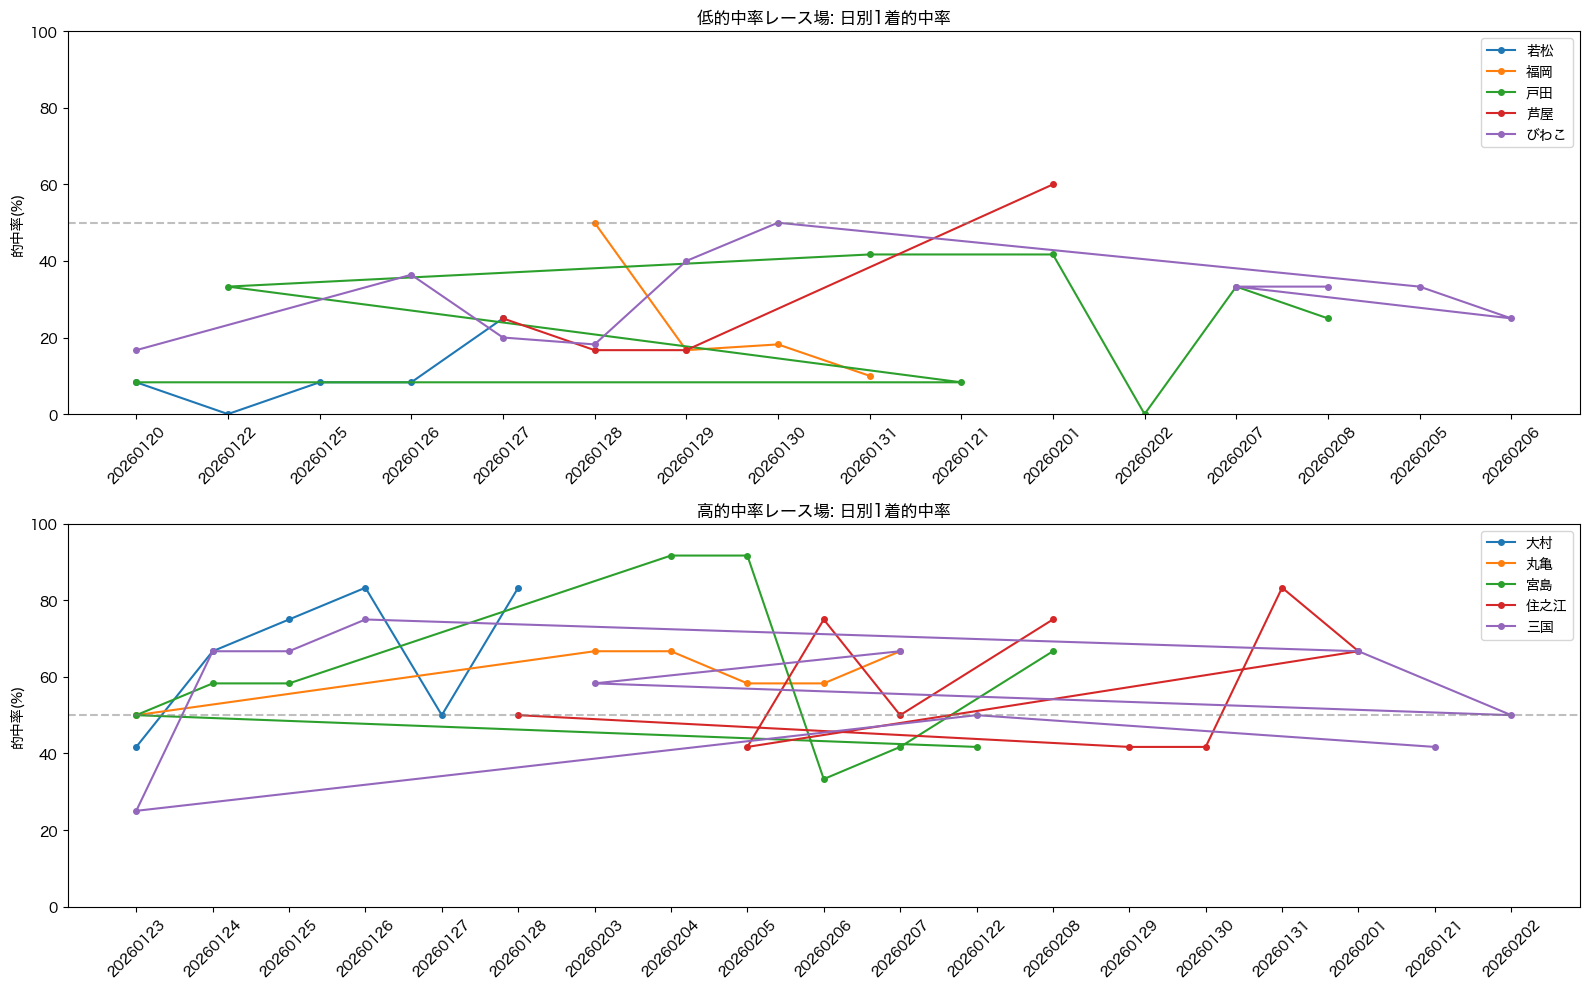

In [37]:
# 7.6 時系列での的中率変動: 問題レース場は特定期間で急変していないか

confirm_ts = confirm.copy()
confirm_ts['日付'] = confirm_ts['レースコード'].str[:8]
confirm_ts['場コード'] = confirm_ts['レースコード'].str[8:10].astype(int)
confirm_ts['的中'] = (confirm_ts['1着的中'] == '○').astype(int)

# 日付×レース場ごとの的中率
daily_acc = confirm_ts.groupby(['日付', '場コード']).agg(
    レース数=('的中', 'count'),
    的中数=('的中', 'sum'),
).reset_index()
daily_acc['的中率'] = (daily_acc['的中数'] / daily_acc['レース数'] * 100).round(1)
daily_acc['場名'] = daily_acc['場コード'].map(STADIUM_CODE_TO_NAME)

# 問題レース場の日別推移
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

ax = axes[0]
for sc in problem_codes:
    d = daily_acc[daily_acc['場コード'] == sc]
    if not d.empty:
        ax.plot(d['日付'], d['的中率'], 'o-', label=STADIUM_CODE_TO_NAME[sc], markersize=4)
ax.set_title('低的中率レース場: 日別1着的中率')
ax.set_ylabel('的中率(%)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

ax = axes[1]
for sc in normal_codes:
    d = daily_acc[daily_acc['場コード'] == sc]
    if not d.empty:
        ax.plot(d['日付'], d['的中率'], 'o-', label=STADIUM_CODE_TO_NAME[sc], markersize=4)
ax.set_title('高的中率レース場: 日別1着的中率')
ax.set_ylabel('的中率(%)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [38]:
# 7.7 深掘り調査のまとめ
print('=== 深掘り調査の総括 ===')
print()
print('【調査1: スコア内訳】')
print('  → ranking_model と classifier のどちらが1号艇を過小評価しているか上記で確認')
print('  → 問題場で rank_1位率・cls_1位率 が低い場合、そのモデル成分に問題あり')
print()
print('【調査2: 特徴量重要度】')
print('  → 問題場と正常場で特徴量の寄与パターンが異なれば、場固有の過学習の可能性')
print('  → イン有利度の重要度が低い問題場は、枠順の有利を学習できていない')
print()
print('【調査3: 学習データ】')
print('  → 問題場の学習レース数が少ない場合、データ不足による不安定な学習')
print('  → 問題場の1号艇勝率が他場と大きく異なる場合、場の特性が反映できていない')
print()
print('【調査4: コースデータ】')
print('  → prediction-preview のコースが全て1なら、進入情報が正しく取得されていない')
print('  → 枠番=コースの前提が崩れるレース場（戸田など前付け多い場）で的中率が下がる')
print()
print('【調査5: 特徴量品質】')
print('  → NaN率やゼロ率に問題場固有の偏りがあれば、fillna処理の改善が必要')

=== 深掘り調査の総括 ===

【調査1: スコア内訳】
  → ranking_model と classifier のどちらが1号艇を過小評価しているか上記で確認
  → 問題場で rank_1位率・cls_1位率 が低い場合、そのモデル成分に問題あり

【調査2: 特徴量重要度】
  → 問題場と正常場で特徴量の寄与パターンが異なれば、場固有の過学習の可能性
  → イン有利度の重要度が低い問題場は、枠順の有利を学習できていない

【調査3: 学習データ】
  → 問題場の学習レース数が少ない場合、データ不足による不安定な学習
  → 問題場の1号艇勝率が他場と大きく異なる場合、場の特性が反映できていない

【調査4: コースデータ】
  → prediction-preview のコースが全て1なら、進入情報が正しく取得されていない
  → 枠番=コースの前提が崩れるレース場（戸田など前付け多い場）で的中率が下がる

【調査5: 特徴量品質】
  → NaN率やゼロ率に問題場固有の偏りがあれば、fillna処理の改善が必要


## 6. まとめと次のステップ

### 発見事項

| # | 項目 | 深刻度 | 根本原因（セクション7で判明） | 対応方針 |
|---|------|--------|-------------------------------|----------|
| 1 | prediction-preview のコースが全艇=1 | **最重大** | 元CSVの時点で全て1（データ取得パイプラインの不具合）。通常previews には正しい進入コースが入っている | データ取得処理を修正し、通常previewsのコース情報を使用 |
| 2 | 「コース」が最重要特徴量なのに情報を持たない | **最重大** | #1の結果、全レース場でコース=1（全艇同値）。モデルはコースを最重要視して学習したが推論時に無意味な入力を受けている | #1の修正で連鎖的に解消 |
| 3 | 体重(kg)が全場NaN率100% | 重大 | prediction-preview に体重データが含まれていない。モデルの特徴量には含まれており、常にfillna(0)で代替 | 特徴量から除外、またはprogramsの体重を使用 |
| 4 | 低的中率レース場の予測偏り | 重大 | 戸田: ens_1位率33.3%（1号艇勝率44%の低イン場で他艇を過大評価）。びわこ: 63.6%。日別のばらつきが大きく、confirm全期間では福岡0%・若松3.3% | #1,#2の修正後に再評価が必要 |
| 5 | 固定イン有利度マップの限界 | 重大 | 全場同一マップ `{1:5, 2:3, 3:2, 4:1, 5:0, 6:0}` だが、実際の1号艇勝率は戸田44%〜大村63%と大差 | データ駆動マップで置換（セクション2で作成済み） |
| 6 | 今節成績のNaN率が問題場で高い | 中 | 問題場40.3% vs 正常場9.5%（差30.7pt）。分析対象日に初日レースが多い問題場で今節データが欠損 | fillna処理の改善（着順系→3.5、率系→全体median） |
| 7 | 日次数の除外 | 中 | 第1日52.0%→第5日58.6%（1号艇勝率）、予測的中率も第1日44.9%→第6日61.7%と顕著な差 | exclude_colsから除外して再学習 |
| 8 | NaN→0のデフォルト値問題 | 中 | 着順系（1-6の範囲）に0を入れると異常値扱いされる。率系も0は「実績なし」と「勝率0%」の区別がつかない | prepare_features の fillna ロジックを改善 |
| 9 | 未使用モデルのストレージ浪費 | 低 | program_models.pkl, stadium_models.pkl がどこからも参照されていない | 削除するだけ |

### 推奨アクション（優先度順）

#### P0: 即座に対応（的中率への影響が最大）

1. **prediction-preview のコースデータ修正** — 通常 previews には正しい進入コース（1〜6の並び替え）が入っている。prediction-preview 生成パイプラインで `艇N_コース` を正しく設定するか、推論時に通常 previews のコースデータを使用する
2. **体重(kg) の対処** — 全場NaN率100%で特徴量として機能していない。programs に体重データがあるならそちらを使用、なければ特徴量から除外して再学習

#### P1: 短期改善（再学習が必要）

3. **`compute_course_features()` のイン有利度マップをデータ駆動化** — セクション2で作成した24場別スケールに置換
4. **`exclude_cols` から `日次数` を除外して再学習** — 節の進行日が予測精度に強い影響を持つことが確認された
5. **`prepare_features()` のNaN処理改善** — 着順系→3.5（中央値）、率系→全体medianに変更

#### P2: 中期改善

6. **戸田など低イン場のモデル精度向上** — 1号艇勝率44%（全場最低）で他場と特性が大きく異なる。場固有の特徴量調整や学習データのバランシングを検討
7. **今節成績NaN率の改善** — 初日レースは今節データがないため、過去節成績や通算成績でフォールバックする仕組みを追加

#### P3: 低優先

8. **未使用モデルファイル削除** — `program_models.pkl`, `stadium_models.pkl` を Git LFS から削除

### 影響度の見積もり

P0（コース修正）は全レース場に影響する。モデルの特徴量重要度で「コース」が全24場で1〜2位を占めており、この特徴量が正しい値を持つだけで大幅な改善が期待できる。特に前付けが多い戸田・江戸川などでは、枠番≠コースのレースが多いため効果が顕著になる。

In [39]:
print('Phase 1 分析完了')

Phase 1 分析完了
